In [6]:
import xarray as xr
import datetime as dt
import os
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import sys
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')

from distance import distance_calculator,pointdist_calc,get_angle
from cylindrical_conversion import interp_to_equal_grid,circle,x_y_grid_to_cylindrical
from scipy import ndimage
from calendar import monthrange
from scipy.interpolate import RegularGridInterpolator
desired_normalized_rad_arr = np.arange(0,6.01,0.01)


In [7]:
def round_to_nearest_half_hour(t):
    if t.minute < 15:
        return t.replace(minute=0, second=0, microsecond=0)
    elif t.minute < 45:
        return t.replace(minute=30, second=0, microsecond=0)
    else:
        if t.hour < 23:
            return (t.replace(hour=t.hour + 1, minute=0, second=0, microsecond=0))
        else:
            days_in_month = monthrange(t.year, t.month)[1]
            if tc_radar_time.day + 1 >  days_in_month:
                return(t.replace(month = t.month+1,day=1, hour=0,
                                             minute=0, second=0,microsecond=0))
            else:
                return(t.replace(day=t.day + 1, hour=0, minute=0, second=0,microsecond=0))

In [8]:
# Settings
imerg_centering = '2-km Center'
height = 2
polar_boolean = True
swath_boolean = True

In [112]:
# small_tilt_list = []
# large_tilt_list = []
# rmw_small_tilt = []
# rmw_large_tilt = []
# tilt_mag_large_list = []
# tilt_mag_small_list = []
# all_last_slices = []

all_last_slices = []
full_info_arr_list = []

vmax_arr_list = []

rad_list = []
cylindrical_normalized_list = []
        

if swath_boolean == True:
    
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_1997_2019_xy_rel_swath_ships.nc?download=1',
                     '/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_2020_2022_xy_rel_swath_ships.nc?download=1']   
else:
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_1997_2019_xy_rel_merge_ships.nc?download=1',
                 '/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_2020_2022_xy_rel_merge_ships.nc?download=1']

    
tc_radar_data_pre = xr.open_mfdataset(nc_file_paths,combine='nested',concat_dim='num_cases')
tc_radar_data_pre['num_cases'] = range(0,len(tc_radar_data_pre['num_cases']))

if swath_boolean == True:
# Snip TC-RADAR Dataset to times wit IMERG data (2000 and later)
    good_inds = tc_radar_data_pre['swath_year'].where(tc_radar_data_pre['swath_year']>=2000).dropna('num_cases')['num_cases']
    tc_radar_data = tc_radar_data_pre.sel(num_cases = good_inds)

    # Identify all storm names and times to find IMERG data closest to TC RADAR Merged Time
    years,months,days,hours,minutes = tc_radar_data['swath_year'].values,\
        tc_radar_data['swath_month'].values,tc_radar_data['swath_day'].values,\
        tc_radar_data['swath_hour'].values,tc_radar_data['swath_min'].values                
else:
# Snip TC-RADAR Dataset to times wit IMERG data (2000 and later)
    good_inds = tc_radar_data_pre['merge_year'].where(tc_radar_data_pre['merge_year']>=2000).dropna('num_cases')['num_cases']
    tc_radar_data = tc_radar_data_pre.sel(num_cases = good_inds)

    # Identify all storm names and times to find IMERG data closest to TC RADAR Merged Time
    years,months,days,hours,minutes = tc_radar_data['merge_year'].values,\
        tc_radar_data['merge_month'].values,tc_radar_data['merge_day'].values,\
        tc_radar_data['merge_hour'].values,tc_radar_data['merge_min'].values


# Find file paths and download any files not in directory

timedeltas = [-60,-30,0,30] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h
# timedeltas = [0] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h

filepaths = []
rounded_time_list = []
for i in range(len(tc_radar_data['num_cases'])):
    curr_time_filepaths = []
    for times in timedeltas:
        tc_radar_time = dt.datetime(years[i],months[i],days[i],hours[i],minutes[i])
        rounded_time = round_to_nearest_half_hour(tc_radar_time)
        time_desired = rounded_time + dt.timedelta(minutes=times)
        print(i,tc_radar_time,rounded_time)

        year = time_desired.year
        day_of_year = time_desired.strftime('%j')
        day_stripped = time_desired.strftime('%Y%m%d')
        time_stripped = time_desired.strftime('%H%M%S')
        min_of_day = str(time_desired.hour*60 + time_desired.minute).zfill(4)
        end_time_stripped = (time_desired+dt.timedelta(minutes=29,seconds=59)).strftime('%H%M%S')

        # If IMERG file does not exist, download it
        IMERG_file_path = '/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year+'/'+\
            '3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+'-E'+end_time_stripped+\
            '.'+min_of_day+'.V07B.HDF5'
        curr_time_filepaths.append(IMERG_file_path)
        print(IMERG_file_path)
        print(os.path.exists(IMERG_file_path))

            # If day directory does not exist, make day directory
        if os.path.exists('/Users/acheung/data/IMERG/'+str(year)) == False:
            os.mkdir('/Users/acheung/data/IMERG/'+str(year))

        if os.path.exists('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year) == False:
            os.mkdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

        if os.path.exists(IMERG_file_path) == False:
            url_desired = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"\
                +str(year)+'/'+day_of_year+'/'+'3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+\
                '-E'+end_time_stripped+'.'+min_of_day+'.V07B.HDF5'
            os.chdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

            os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                      + url_desired)
    filepaths.append(curr_time_filepaths)
    rounded_time_list.append(rounded_time)

all_time_filepaths = pd.DataFrame(filepaths)
all_time_filepaths.index = tc_radar_data['num_cases'].astype(int)

time_list_pd = pd.DataFrame(rounded_time_list)
time_list_pd.index = tc_radar_data['num_cases'].astype(int)

case_loop_list = []
for case_loop in tc_radar_data['num_cases'].astype(int).values: # Run all
#     for case_loop in [90]: # Custom Start and End

    # Only do storms that are tropical or subtropical, if neither, continue loop
    stype_ships = float(tc_radar_data['stype_ships'].sel(num_cases=case_loop,num_ships_times = 0).values)
    if (stype_ships != 1) and (stype_ships != 2):
        print('skipped '+ str(case_loop))
        continue

    # Open IMERG
        print(case_loop)
    precip_list = []
    for now_it in range(len(all_time_filepaths.loc[case_loop])):
        fn = all_time_filepaths.loc[case_loop][now_it]
        f = h5py.File(fn, 'r')

        # Work on precip file
        groups = [ x for x in f.keys() ]
        # print(groups)
        gridMembers = [ x for x in f['Grid'] ]
        # print(gridMembers)

        # Get the precipitation, latitude, and longitude variables
        precip = f['Grid/precipitation'][0][:][:]
        precip = np.transpose(precip)
        precip[precip<-999]=np.nan

        theLats = f['Grid/lat'][:]
        theLons = f['Grid/lon'][:]
        x, y = np.float32(np.meshgrid(theLons, theLats))

        precip_list.append(precip)

    # For now, we take a mean. Might need a different filter in the future
    precip_mean = np.mean(np.asarray(precip_list),axis=0)

    # Find interpolated storm-center
    # Get Storm Name and time
    storm_name = str(tc_radar_data['storm_name'].sel(num_cases=case_loop).values)

    # Overall Subplot Title
    bt_vmax = tc_radar_data['vmax_ships'].sel(num_cases=case_loop).sel(num_ships_times=0).values
    bt_intensity_arr = tc_radar_data['vmax_ships'].sel(num_cases=case_loop).values

#         if sorting_type == 'tilt': # We only do weak storms for tilt sorting
#             if float(bt_vmax) > 65: # Only record weak storm cases
#                 print('Skipped '+ str(case_loop) + ' due to strong storm of ' + str(bt_vmax) + ' kt')
#                 continue

    nearest_30_min_ts = time_list_pd.loc[case_loop][0].timestamp()
    bt_times = tc_radar_data.sel(num_cases=case_loop)['num_ships_times'].where(tc_radar_data.sel(num_cases=case_loop)['lat_ships'].notnull()).dropna('num_ships_times').values
    bt_lats = tc_radar_data.sel(num_cases=case_loop)['lat_ships'].dropna('num_ships_times').values
    bt_lons = tc_radar_data.sel(num_cases=case_loop)['lon_ships'].dropna('num_ships_times').values * -1

    if swath_boolean == True:
        year_now,month,day,hour,minute = tc_radar_data['swath_year'].sel(num_cases=case_loop).values,\
            tc_radar_data['swath_month'].sel(num_cases=case_loop).values,tc_radar_data['swath_day'].sel(num_cases=case_loop).values,\
            tc_radar_data['swath_hour'].sel(num_cases=case_loop).values,tc_radar_data['swath_min'].sel(num_cases=case_loop).values
    else:
        year_now,month,day,hour,minute = tc_radar_data['merge_year'].sel(num_cases=case_loop).values,\
            tc_radar_data['merge_month'].sel(num_cases=case_loop).values,tc_radar_data['merge_day'].sel(num_cases=case_loop).values,\
            tc_radar_data['merge_hour'].sel(num_cases=case_loop).values,tc_radar_data['merge_min'].sel(num_cases=case_loop).values

    radar_time = dt.datetime(year_now,month,day,hour,minute)
    nearest_syn_ts = pd.DataFrame([radar_time])[0].dt.round("6h")[0].timestamp()

    time_secs_arr = nearest_syn_ts + (bt_times * 3600)

    # Don't plot best-track (SHIPS) center if there is no information
    if imerg_centering == '2-km Center':
        centering_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop,level=height).values
        centering_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop,level=height).values
        # For cases that use 2-km centering, we need a center here to exist, duhh
        if (str(centering_lat) == 'nan') or (str(centering_lon) == 'nan'): 
            print('No Center, skipped')
            continue
    elif imerg_centering == 'best-track':
        if len(bt_lats) > 0:
            latspl = UnivariateSpline(time_secs_arr,bt_lats,k=2,s=0)
            centering_lat = latspl(nearest_30_min_ts)
        if len(bt_lons) > 0:
            lonspl = UnivariateSpline(time_secs_arr,bt_lons,k=2,s=0)
            centering_lon = lonspl(nearest_30_min_ts)

    # Find index closest to interpolated best-track center or 2-km radar center
    distance_arr = distance_calculator(x, y,(centering_lon,centering_lat))

    abs_dist_arr = (abs(distance_arr))

    min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

    # Find tilt magnitude and tilt direction from TC-RADAR

    '''
    Find the tilt magnitude and tilt direction (mat angle). We take the highest 
    tilt height available between 5 and 6.5 km
    '''

    tilt_mag = (tc_radar_data.sel(num_cases=case_loop,level=[5,5.5,6,6.5])[
        'tc_tilt_magnitude'].dropna(dim='level'))

    if len(tilt_mag) == 0:
        continue
    tilt_mag_use = np.nanmax(tilt_mag.values)
    print(tilt_mag_use)

    rotate_setting = 'Shear-Direction'
    
    if rotate_setting == 'Tilt-Direction':
        angle_rotate = (tc_radar_data.sel(num_cases=case_loop,level=[5,5.5,6,6.5])[
            'tc_tilt_direction'].dropna(dim='level').values* (180/np.pi))[np.nanargmax(tilt_mag.values)] # This is a math angle!!!
    elif rotate_setting == 'Shear-Direction':
        angle_rotate = 90 - float(tc_radar_data['shtd_ships'].sel(num_cases=case_loop,num_ships_times=0))

    # Find distance and angle of 6km-level center

    mid_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop,level=[5,5.5,6,6.5]).values[np.nanargmax(tilt_mag.values)]
    mid_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop,level=[5,5.5,6,6.5]).values[np.nanargmax(tilt_mag.values)]

    dist_to_mid_center = pointdist_calc(mid_lat,mid_lon,centering_lat,centering_lon)

    # This is NOT a perfect estimate of the angle, given the Earth's curvature

    angle_to_mlc = get_angle(centering_lon,centering_lat,mid_lon,mid_lat) # degrees from math angle zero, or east

    # Slice arrays to within 100 indices of interpolated best-track center

    sliced_lon_grid = x[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    sliced_lat_grid = y[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    sliced_precip = precip_mean[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    # NEVER FORGET TO MULTIPLY RADIUS ARRAYS BY DX FOR IMERG PLOTS!!!

    dx = 2
    dy = 2

    # Interpolate IMERG data to equal-distance grid

    eq_lon_grid,eq_lat_grid,eq_dist_data = interp_to_equal_grid(sliced_lon_grid,sliced_lat_grid,
                                                            sliced_precip,dx = dx,dy=dy)


    distance_arr_sliced = distance_calculator(eq_lon_grid, eq_lat_grid,(centering_lon,centering_lat))

    abs_dist_arr_sliced = (abs(distance_arr_sliced))

    min_dist_ind_sliced = np.where(abs_dist_arr_sliced == np.nanmin(abs_dist_arr_sliced))

    pts_above = eq_dist_data.shape[0] - min_dist_ind_sliced[0][0]
    y_range = np.arange(-min_dist_ind_sliced[0][0],pts_above) * dy

    pts_right = eq_dist_data.shape[1] - min_dist_ind_sliced[1][0]
    x_range = np.arange(-min_dist_ind_sliced[1][0],pts_right) * dx

    xv, yv = np.meshgrid(x_range, y_range)

    x_range.shape[0],np.where(x_range==0)[0][0]

    x_zero_loc = np.where(x_range==0)[0][0]

    if x_zero_loc > x_range.shape[0]/2:
        x_offset = int(x_range.shape[0]-x_zero_loc)
    elif x_zero_loc <= x_range.shape[0]/2:
        x_offset = x_zero_loc

    y_zero_loc = np.where(y_range==0)[0][0]

    if y_zero_loc > y_range.shape[0]/2:
        y_offset = int(y_range.shape[0]-y_zero_loc)
    elif y_zero_loc <= y_range.shape[0]/2:
        y_offset = y_zero_loc

    x_even_inds = x_range[x_zero_loc-(x_offset-1):x_zero_loc+x_offset+1]
    y_even_inds = y_range[y_zero_loc-(y_offset-1):y_zero_loc+y_offset+1]

    sliced_eq_data_pd = pd.DataFrame(eq_dist_data,columns=x_range,index=y_range)

    evenly_sliced_pd = sliced_eq_data_pd[x_even_inds].loc[y_even_inds]

    x_evenly_sliced, y_evenly_sliced = np.meshgrid(x_even_inds, y_even_inds)

    print(angle_rotate)
    

    img_rotate = ndimage.rotate(evenly_sliced_pd, angle_rotate, reshape=False,cval=np.nan)
    img_rotate_pd = pd.DataFrame(img_rotate,columns=evenly_sliced_pd.columns,index=evenly_sliced_pd.index)

    pd_last_slice = img_rotate_pd[np.arange(-150,150.1,2)].loc[-150:150]
    x_evenly_last_sliced, y_evenly_last_sliced = np.meshgrid(pd_last_slice.columns, pd_last_slice.index)

    # Find location of MLC on tilt-relative grid

    mlc_rotated_angle = angle_to_mlc - angle_rotate

    mlc_x = dist_to_mid_center * np.cos(mlc_rotated_angle*(np.pi/180))
    mlc_y = dist_to_mid_center * np.sin(mlc_rotated_angle*(np.pi/180))

#         plt.figure()
#         plt.contourf(x_evenly_last_sliced, y_evenly_last_sliced,pd_last_slice)
#         plt.scatter(0,0,label=imerg_centering)
#         plt.scatter(mlc_x,mlc_y,label='MLC')
#         plt.grid()
#         plt.legend()

    rmw_now = tc_radar_data['tc_rmw'].sel(num_cases=case_loop,level=height).values
    shear_now = tc_radar_data['shrd_ships'].sel(num_cases=case_loop).sel(num_ships_times=0).values
    dtl_now = tc_radar_data['dtl_ships'].sel(num_cases=case_loop,num_ships_times=0).values
#         if sorting_type == 'tilt':
#             if tilt_mag_use < 40: #km for small tilt
#                 small_tilt_list.append(pd_last_slice)
#                 rmw_small_tilt.append(rmw_now)
#                 tilt_mag_small_list.append(tilt_mag_use)
#                 print(case_loop,'Small-Tilt')
#             elif tilt_mag_use >= 40: #km for large tilt
#                 large_tilt_list.append(pd_last_slice) 
#                 rmw_large_tilt.append(rmw_now)
#                 tilt_mag_large_list.append(tilt_mag_use)
#                 print(case_loop,'Large-Tilt')
#         elif sorting_type == 'intensity':

    all_last_slices.append(pd_last_slice)
    
    

    full_info_col_names = ['Storm Name','Time','Tilt Magnitude','Intensity',
                           'RMW','Deep-Layer Shear','DTL','MLC X','MLC Y']
    full_info_arr = [storm_name,time_list_pd.loc[case_loop][0],tilt_mag_use,bt_vmax,rmw_now,shear_now,dtl_now,mlc_x,mlc_y]
    full_info_arr_list.append(full_info_arr)

    vmax_arr_list.append(bt_intensity_arr)


    if polar_boolean == True:
        cylindrical_data, THETA, rad_arr = x_y_grid_to_cylindrical(
            center_inds=[0,0],radius_min=0,radius_max=500,radius_interval=1, NOP=1000,
            x_grid=img_rotate_pd.index.values,y_grid=img_rotate_pd.columns.values,
            data=img_rotate_pd.values)

        # Interpolate data to normalized RMW spacings
        normalized_rad_arr = rad_arr/rmw_now

        polar_interp = RegularGridInterpolator((normalized_rad_arr,THETA), cylindrical_data,bounds_error=False)

        theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)
        polar_rad_norm_data = polar_interp((desired_rad_mesh,THETA))            

        cylindrical_normalized_list.append(polar_rad_norm_data)
        
    case_loop_list.append(case_loop) # This needs to be at the end of the for loop to guarantee continues are applied

#         fig = plt.figure() 

#         gs = fig.add_gridspec(1,1)
#         ax1 = fig.add_subplot(gs[0, 0],projection='polar')
#         ax1.grid(True)
#         ax1.set_theta_direction(-1)
#         ax1.set_theta_zero_location('N')
#         ax1.contourf(THETA, desired_normalized_rad_arr,polar_rad_norm_data)
#         ax1.set_title(str(rmw_now))
#         fig = plt.figure() 

#         gs = fig.add_gridspec(1,1)
#         ax2 = fig.add_subplot(gs[0, 0],projection='polar')
#         ax2.grid(True)
#         ax2.set_theta_direction(-1)
#         ax2.set_theta_zero_location('N')
#         ax2.contourf(THETA, rad_arr,cylindrical_data)
#         ax2.set_title(str(rmw_now))



0 2003-09-03 17:20:00 2003-09-03 17:30:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S163000-E165959.0990.V07B.HDF5
True
0 2003-09-03 17:20:00 2003-09-03 17:30:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S170000-E172959.1020.V07B.HDF5
True
0 2003-09-03 17:20:00 2003-09-03 17:30:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S173000-E175959.1050.V07B.HDF5
True
0 2003-09-03 17:20:00 2003-09-03 17:30:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S180000-E182959.1080.V07B.HDF5
True
1 2003-09-03 18:50:00 2003-09-03 19:00:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S180000-E182959.1080.V07B.HDF5
True
1 2003-09-03 18:50:00 2003-09-03 19:00:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S183000-E185959.1110.V07B.HDF5
True
1 2003-09-03 18:50:00 2003-09-03 19:00:00
/Users/acheung/data/IMERG/2003/246/3B-HHR.MS.MRG.3IMERG.20030903-S190000-E192959.1140.V07B.HDF5
True

1027 2022-09-01 09:20:00 2022-09-01 09:30:00
/Users/acheung/data/IMERG/2022/244/3B-HHR.MS.MRG.3IMERG.20220901-S090000-E092959.0540.V07B.HDF5
True
1027 2022-09-01 09:20:00 2022-09-01 09:30:00
/Users/acheung/data/IMERG/2022/244/3B-HHR.MS.MRG.3IMERG.20220901-S093000-E095959.0570.V07B.HDF5
True
1027 2022-09-01 09:20:00 2022-09-01 09:30:00
/Users/acheung/data/IMERG/2022/244/3B-HHR.MS.MRG.3IMERG.20220901-S100000-E102959.0600.V07B.HDF5
True
1028 2022-09-01 10:29:00 2022-09-01 10:30:00
/Users/acheung/data/IMERG/2022/244/3B-HHR.MS.MRG.3IMERG.20220901-S093000-E095959.0570.V07B.HDF5
True
1028 2022-09-01 10:29:00 2022-09-01 10:30:00
/Users/acheung/data/IMERG/2022/244/3B-HHR.MS.MRG.3IMERG.20220901-S100000-E102959.0600.V07B.HDF5
True
1028 2022-09-01 10:29:00 2022-09-01 10:30:00
/Users/acheung/data/IMERG/2022/244/3B-HHR.MS.MRG.3IMERG.20220901-S103000-E105959.0630.V07B.HDF5
True
1028 2022-09-01 10:29:00 2022-09-01 10:30:00
/Users/acheung/data/IMERG/2022/244/3B-HHR.MS.MRG.3IMERG.20220901-S110000-E11295

6.3245554
108.43495
2.0
90.0
4.472136
63.43495
6.3245554
71.56505
2.0
90.0
4.472136
63.43495
6.3245554
71.56505
6.0
90.0
6.0
90.0
4.0
-90.0
2.0
-90.0
No Center, skipped
4.472136
26.565052
2.828427
-45.0
2.828427
45.0
4.472136
63.43495
8.246211
14.036243
2.828427
135.0
2.828427
135.0
4.0
180.0
2.0
90.0
4.472136
-116.56505
4.0
0.0
2.828427
45.0
4.0
0.0
4.472136
26.565052
4.472136
63.43495
7.2111025
33.690067
10.770329
21.80141
2.0
0.0
6.3245554
18.434948
2.828427
45.0
2.0
0.0
4.472136
26.565052
2.0
90.0
6.3245554
108.43495
6.3245554
108.43495
6.3245554
108.43495
2.828427
45.0
2.828427
45.0
No Center, skipped
2.828427
45.0
2.828427
45.0
2.0
90.0
8.246211
75.96376
8.0
90.0
8.0
90.0
8.246211
75.96376
10.770329
111.80141
10.0
126.8699
2.828427
135.0
8.0
90.0
4.0
90.0
6.0
90.0
4.472136
116.56505
7.2111025
56.309933
7.2111025
56.309933
4.472136
63.43495
8.485281
45.0
8.246211
75.96376
7.2111025
56.309933
5.656854
45.0
8.485281
45.0
7.2111025
56.309933
10.0
36.869896
7.2111025
33.690067
7.21110

/Users/acheung/TC_RI_P1/scripts/Useful Functions/distance.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1.-a))


6.0
90.0
8.246211
75.96376
6.0
90.0
6.3245554
-108.43495
8.246211
-75.96376
11.661903
-120.96376
5.656854
45.0
4.472136
63.43495
172.62677
10.00798
174.1838
2.632435
105.26158
38.829823
No Center, skipped
No Center, skipped
4.472136
-153.43495
2.828427
-45.0
12.165525
99.462326
10.0
-126.8699
4.472136
-63.43495
skipped 158
skipped 159
skipped 160
skipped 161
No Center, skipped
90.44335
-18.034286
No Center, skipped
skipped 165
skipped 166
17.20465
35.537678
12.165525
9.462322
17.20465
54.462322
17.20465
54.462322
5.656854
45.0
11.661903
59.036243
14.422205
56.309933
4.472136
-26.565052
4.472136
26.565052
15.6205
129.80557
12.806249
141.3402
11.313708
135.0
10.198039
78.69007
10.0
90.0
10.770329
111.80141
5.656854
135.0
10.0
90.0
10.770329
111.80141
4.0
90.0
7.2111025
123.69007
8.944272
63.43495
10.198039
101.30993
10.0
90.0
10.770329
111.80141
11.661903
120.96376
8.944272
153.43495
2.0
180.0
2.0
180.0
2.828427
135.0
2.0
90.0
0.0
0.0
2.828427
-45.0
2.828427
-45.0
2.828427
-45.0
4.472136

/Users/acheung/TC_RI_P1/scripts/Useful Functions/distance.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1.-a))


12.165525
-170.53767
6.3245554
161.56505
8.0
180.0
5.656854
-135.0
6.3245554
-108.43495
14.142136
98.130104
15.231546
113.19859
10.770329
111.80141
6.0
90.0
10.198039
78.69007
11.661903
120.96376
6.3245554
108.43495
8.485281
135.0
5.656854
135.0
4.472136
116.56505
5.656854
135.0
4.472136
153.43495
4.472136
116.56505
48.0
0.0
90.44335
35.095818
No Center, skipped
76.55064
33.27489
66.0303
35.134193
18.439089
12.528809
18.439089
12.528809
22.090721
5.194429
7.2111025
-123.69007
8.944272
-63.43495
10.0
-90.0
2.828427
45.0
2.0
-90.0
2.0
0.0
2.828427
-45.0
12.165525
9.462322
14.56022
15.945396
14.422205
33.690067
12.165525
-9.462322
14.142136
8.130103
16.492422
14.036243
17.888544
26.565052
14.422205
33.690067
10.0
36.869896
14.422205
56.309933
10.770329
68.19859
14.142136
45.0
11.661903
59.036243
5.656854
45.0
4.472136
63.43495
2.828427
45.0
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
8.246211
104.03624
61.77378
-60.945396
No Center, skipp

4.0
90.0
10.0
126.8699
8.246211
165.96376
4.472136
116.56505
6.0
90.0
4.472136
116.56505
4.472136
153.43495
4.472136
153.43495
No Center, skipped
4.0
180.0
4.472136
153.43495
4.472136
153.43495
10.198039
168.69008
skipped 1021
skipped 1022
skipped 1023
skipped 1024
skipped 1025
skipped 1026
skipped 1027
skipped 1028
skipped 1029
skipped 1030
skipped 1031
skipped 1032
skipped 1033
skipped 1034
skipped 1035
skipped 1036
skipped 1037
skipped 1038
skipped 1039
skipped 1040
skipped 1041
skipped 1042
No Center, skipped
172.62677
10.00798
No Center, skipped
83.25864
65.897766
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
66.0303
35.134193
No Center, skipped
156.98407
44.483837
178.28067
46.818302
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
78.0
67.380135
No Center, skipped


/Users/acheung/TC_RI_P1/scripts/Useful Functions/distance.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1.-a))


18.110771
96.34019
29.12044
74.0546
38.470768
62.10273
34.058773
40.23636
38.832977
55.491478
42.379242
70.70996
39.293766
75.25644
52.49762
72.255325
32.31099
111.80141
24.33105
80.53768
25.298222
71.56505
24.0
90.0
16.124516
97.125015
24.738634
75.96376
32.984844
75.96376
16.124516
60.255116
18.973665
71.56505
18.439089
102.52881
28.635643
77.90524
No Center, skipped
No Center, skipped
No Center, skipped
10.198039
168.69008
10.198039
101.30993
5.656854
-45.0
6.3245554
18.434948
No Center, skipped
2.828427
135.0
4.472136
26.565052
No Center, skipped
No Center, skipped
No Center, skipped
6.3245554
18.434948
No Center, skipped
No Center, skipped
No Center, skipped
No Center, skipped
73.78347
-32.828545
12.165525
-99.462326
16.492422
14.036243
26.305893
81.25384
25.612497
51.340195
15.6205
50.19443
24.41311
55.00798
10.198039
78.69007
10.198039
78.69007
10.198039
78.69007
8.485281
45.0
7.2111025
33.690067
10.0
36.869896
12.649111
71.56505
7.2111025
56.309933
4.472136
63.43495
4.0
90.0
4.

/Users/acheung/TC_RI_P1/scripts/Useful Functions/distance.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1.-a))


14.0
0.0
10.198039
-11.309933
2.828427
-135.0
2.0
0.0
6.3245554
108.43495
4.472136
63.43495
5.656854
45.0
6.3245554
71.56505
13.416408
153.43495
22.803509
-74.74488
27.856777
-68.96249
41.761227
-73.30076
21.260292
48.81408
16.124516
82.874985
0.0
0.0
2.828427
135.0
4.472136
-116.56505
skipped 1157
skipped 1158
skipped 1159
skipped 1160
skipped 1161
skipped 1162
skipped 1163
skipped 1164
skipped 1165
skipped 1166
skipped 1167
No Center, skipped
No Center, skipped
6.3245554
161.56505
4.0
180.0
7.2111025
146.30994
24.738634
104.03624
16.492422
104.03624
20.396078
101.30993
56.0357
34.824493
34.98571
59.036243
35.44009
73.61046
106.451866
64.39781
63.560993
114.145546
58.137768
116.56505
39.293766
165.25644
11.661903
59.036243
16.0
90.0
10.0
36.869896
14.142136
81.869896
11.661903
59.036243
4.472136
116.56505
19.79899
45.0
20.09975
95.710594
18.439089
40.601295


In [113]:
# mid_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop,level=6).values
# mid_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop,level=6).values

# dist_to_mid_center = pointdist_calc(mid_lat,mid_lon,centering_lat,centering_lon)

# # This is NOT a perfect estimate of the angle, given the Earth's curvature

# angle_to_mlc = get_angle(centering_lon,centering_lat,mid_lon,mid_lat) # degrees from math angle zero, or east
# plt.pcolormesh(eq_lon_grid,eq_lat_grid,eq_dist_data)
# plt.scatter(mid_lon,mid_lat,label='mlc')
# plt.scatter(centering_lon,centering_lat,label='bt')
# plt.legend()
# print(centering_lon,centering_lat,mid_lon,mid_lat,angle_to_mlc)

In [115]:
finalx,finaly = np.meshgrid(pd_last_slice.columns,pd_last_slice.index)

# NEED TO FIX DATAFRAME INDEX HERE!!! 

full_info_pd = pd.DataFrame(full_info_arr_list,columns=full_info_col_names,index=case_loop_list)
vmax_arr_pd = pd.DataFrame(vmax_arr_list,columns=tc_radar_data['vmax_ships']['num_ships_times'].values,
                          index=case_loop_list)

finalx,finaly = np.meshgrid(pd_last_slice.columns,pd_last_slice.index)

all_last_slices_xr = xr.DataArray(all_last_slices,dims=["case","x", "y"],coords=dict(
        x=(["x", "y"], finalx),
        y=(["x", "y"], finaly),
        case=(case_loop_list)
    ))

all_last_slices_xr.to_netcdf('/Users/acheung/data/Composite_Data/imerg_composites.nc')


theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)

all_cylindrical_xr = xr.DataArray(cylindrical_normalized_list,dims=["case","radius", "azimuth"],coords=dict(
        azimuth=(["radius", "azimuth"], theta_mesh),
        radius=(["radius", "azimuth"], desired_rad_mesh),
               case=(case_loop_list)
    ))

all_cylindrical_xr.to_netcdf('/Users/acheung/data/Composite_Data/cylindrical_composite.nc')
full_info_pd.to_csv('/Users/acheung/data/Composite_Data/Composite_info.csv')
vmax_arr_pd.to_csv('/Users/acheung/data/Composite_Data/vmax_arr_arrs.csv')

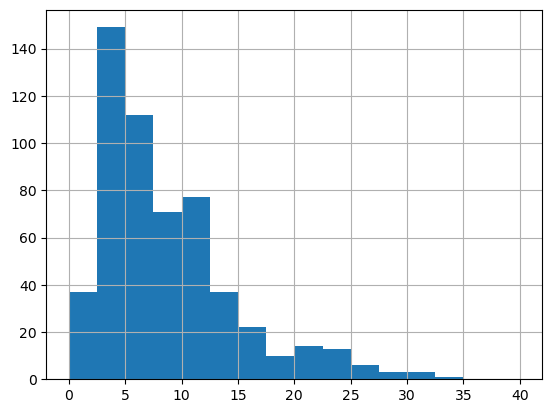

In [9]:
# Open Saved Data

vmax_arr_pd = pd.read_csv('/Users/acheung/data/Composite_Data/vmax_arr_arrs.csv',index_col=0)
vmax_arr_pd.columns = vmax_arr_pd.columns.astype(float)
full_info_pd = pd.read_csv('/Users/acheung/data/Composite_Data/Composite_info.csv',index_col=0)
all_last_slices_xr = xr.open_dataset('/Users/acheung/data/Composite_Data/imerg_composites.nc')
all_last_slices_xr = all_last_slices_xr['__xarray_dataarray_variable__']

all_cylindrical_xr = xr.open_dataset('/Users/acheung/data/Composite_Data/cylindrical_composite.nc')
all_cylindrical_xr = all_cylindrical_xr['__xarray_dataarray_variable__']

dtl_toggle = True

if dtl_toggle == True:
    full_info_pd = full_info_pd.where(full_info_pd['DTL'] >= 50).dropna() # Dropped storms less than 50 km away from land

    all_last_slices_xr = all_last_slices_xr.sel(case = full_info_pd.index)

    all_cylindrical_xr = all_cylindrical_xr.sel(case = full_info_pd.index)

# Sort by Tilt Variables (for weak cases)

weak_storms_info_pd = full_info_pd.where(full_info_pd['Intensity'] <= 65).dropna() # kt (threshold for weak storms)
small_tilt_indices = weak_storms_info_pd.where(weak_storms_info_pd['Tilt Magnitude'] < 40).dropna().index
large_tilt_indices = weak_storms_info_pd.where(weak_storms_info_pd['Tilt Magnitude'] >= 40).dropna().index    

small_tilt_cases = all_last_slices_xr.sel(case = small_tilt_indices)
small_tilt_rmws = full_info_pd.loc[small_tilt_indices]['RMW']
small_tilt_mlcs_x = full_info_pd.loc[small_tilt_indices]['MLC X']
small_tilt_mlcs_y = full_info_pd.loc[small_tilt_indices]['MLC Y']
large_tilt_cases = all_last_slices_xr.sel(case = large_tilt_indices)
large_tilt_rmws = full_info_pd.loc[large_tilt_indices]['RMW']
large_tilt_mlcs_x = full_info_pd.loc[large_tilt_indices]['MLC X']
large_tilt_mlcs_y = full_info_pd.loc[large_tilt_indices]['MLC Y']

# Sort by tilt bins (for strong cases)

# Sort by Intensity Variables
weak_indices = full_info_pd.where(full_info_pd['Intensity'] <=65).dropna().index
strong_indices = full_info_pd.where(full_info_pd['Intensity'] > 65).dropna().index
weak_cases_imerg = all_last_slices_xr.sel(case = weak_indices)
strong_cases_imerg = all_last_slices_xr.sel(case = strong_indices)
weak_cases_rmw = full_info_pd.loc[weak_indices]['RMW']
strong_cases_rmw = full_info_pd.loc[strong_indices]['RMW']
weak_cases_mlcs_x = full_info_pd.loc[weak_indices]['MLC X']
weak_cases_mlcs_y = full_info_pd.loc[weak_indices]['MLC Y']
strong_cases_mlcs_x = full_info_pd.loc[strong_indices]['MLC X']
strong_cases_mlcs_y = full_info_pd.loc[strong_indices]['MLC Y']

# Sort by Intensity Change

future_time = 12
future_change = vmax_arr_pd[future_time]-vmax_arr_pd[0]

# Toggle Storm Intensity Filtering (only affects intensity change cases)

storm_intensity_filter = 'Weak Only'

if storm_intensity_filter == 'Weak Only':
    future_change = future_change[weak_indices]
    
# Toggle Shear Filtering (only affects intensity change plotting)

shear_criteria = 'none'

if shear_criteria == 'none':
    RI_cases = future_change.where(future_change >= 20).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20)).dropna()
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5)).dropna()
    Weakening_cases = future_change.where(future_change < -5).dropna()
if shear_criteria == 'weak':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna() 
if shear_criteria == 'moderate':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()

if shear_criteria == 'moderate or stronger':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    
if shear_criteria == 'strong':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()

RI_imerg_data = all_last_slices_xr.sel(case = RI_cases.index)
intensifying_imerg_data = all_last_slices_xr.sel(case = Intensifying_cases.index)
SS_imerg_data = all_last_slices_xr.sel(case = SS_cases.index)
weakening_imerg_data = all_last_slices_xr.sel(case = Weakening_cases.index)

RI_rmw = full_info_pd.loc[RI_cases.index]['RMW']
intensifying_rmw = full_info_pd.loc[Intensifying_cases.index]['RMW']
SS_rmw = full_info_pd.loc[SS_cases.index]['RMW']
Weakening_rmw = full_info_pd.loc[Weakening_cases.index]['RMW']

weakening_cases_mlcs_x = full_info_pd.loc[Weakening_cases.index]['MLC X']
weakening_cases_mlcs_y = full_info_pd.loc[Weakening_cases.index]['MLC Y']

intensifying_cases_mlcs_x = full_info_pd.loc[Intensifying_cases.index]['MLC X']
intensifying_cases_mlcs_y = full_info_pd.loc[Intensifying_cases.index]['MLC Y']

SS_cases_mlcs_x = full_info_pd.loc[SS_cases.index]['MLC X']
SS_cases_mlcs_y = full_info_pd.loc[SS_cases.index]['MLC Y']

RI_cases_mlcs_x = full_info_pd.loc[RI_cases.index]['MLC X']
RI_cases_mlcs_y = full_info_pd.loc[RI_cases.index]['MLC Y']

# Organize strong cases by tilt magnitude bins
strong_storm_tilts = full_info_pd.loc[strong_indices]['Tilt Magnitude']

plt.hist(strong_storm_tilts,bins=np.arange(0,40.1,2.5))
plt.grid()

tilt_bin_edges = [4,8,12,16,20,24,28,36]

bin_list = [] # Put each storm's tilts into bins, including the index, which will be used later

for bin_i in range(len(tilt_bin_edges)):
    if bin_i == 0:
        bin_edge_now_tilt = strong_storm_tilts.where(strong_storm_tilts < tilt_bin_edges[bin_i]).dropna()
    else:
        bin_edge_now_tilt = strong_storm_tilts.where((strong_storm_tilts < tilt_bin_edges[bin_i]
                                 ) & (strong_storm_tilts >= tilt_bin_edges[bin_i-1])).dropna()

    bin_list.append(bin_edge_now_tilt)

In [10]:
RI_stats = np.mean(full_info_pd.loc[RI_cases.index][['Tilt Magnitude','Intensity',
                                                     'RMW','Deep-Layer Shear','DTL',
                                                     'MLC X','MLC Y']],axis=0)
Intensifying_stats = np.mean(full_info_pd.loc[Intensifying_cases.index][['Tilt Magnitude',
                                                                         'Intensity','RMW',
                                                                         'Deep-Layer Shear',
                                                                         'DTL','MLC X','MLC Y']],axis=0)
SS_stats = np.mean(full_info_pd.loc[SS_cases.index][['Tilt Magnitude',
                                                     'Intensity','RMW',
                                                     'Deep-Layer Shear',
                                                     'DTL','MLC X','MLC Y']],axis=0)
Weakening_stats = np.mean(full_info_pd.loc[Weakening_cases.index][['Tilt Magnitude',
                                                                   'Intensity','RMW',
                                                                   'Deep-Layer Shear',
                                                                   'DTL','MLC X','MLC Y']],axis=0)


strong_case_stats = np.mean(full_info_pd.loc[strong_indices][['Tilt Magnitude',
                                                              'Intensity','RMW',
                                                              'Deep-Layer Shear',
                                                              'DTL','MLC X','MLC Y']],axis=0)
weak_case_stats = np.mean(full_info_pd.loc[weak_indices][['Tilt Magnitude',
                                                          'Intensity','RMW',
                                                          'Deep-Layer Shear',
                                                          'DTL','MLC X','MLC Y']],axis=0)

# print(RI_stats,Intensifying_stats,SS_stats,Weakening_stats)

pd.DataFrame(Weakening_stats,columns=['Weakening']).transpose()
pd.DataFrame(SS_stats,columns=['Steady-State']).transpose()
pd.DataFrame(Intensifying_stats,columns=['Slowly Intensifying']).transpose()
pd.DataFrame(RI_stats,columns=['RI']).transpose()

,Tilt Magnitude,Intensity,RMW,Deep-Layer Shear,DTL,MLC X,MLC Y
RI,19.80693,57.916667,56.833333,9.891667,218.416667,19.82259,0.018945


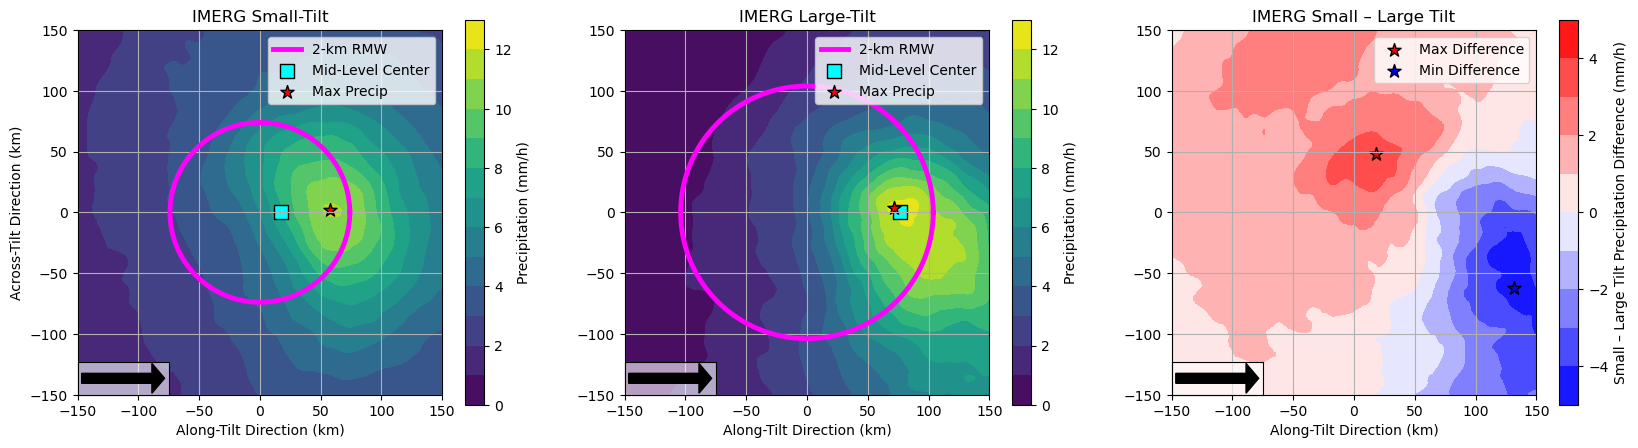

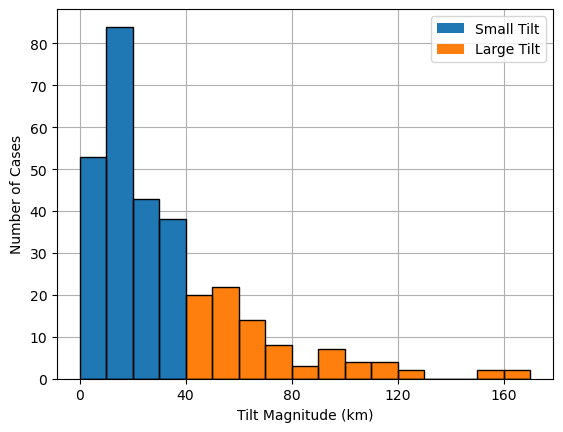

In [11]:
# Plot composites by tilt

large_tilt_mean = large_tilt_cases.mean('case')
small_tilt_mean = small_tilt_cases.mean('case')

large_tilt_Z = 300*(large_tilt_mean **(1.35))
large_tilt_dBZ = 10*np.log10(large_tilt_Z)

small_tilt_Z = 300*(small_tilt_mean **(1.35))
small_tilt_dBZ = 10*np.log10(small_tilt_Z)


# Identify mean MLC X and Y

mean_large_tilt_mlc_x = large_tilt_mlcs_x.mean()
mean_large_tilt_mlc_y = large_tilt_mlcs_y.mean()
mean_small_tilt_mlc_x = small_tilt_mlcs_x.mean()
mean_small_tilt_mlc_y = small_tilt_mlcs_y.mean()

mode = 'Precip'

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

# Draw Circle

X,Y,THETA = circle([0,0],small_tilt_rmws.mean(),1000)

if mode == 'dBZ':
    weak_cf = ax.contourf(small_tilt_dBZ['x'], small_tilt_dBZ['y'],small_tilt_dBZ,np.arange(18,42.1,2))
#     weak_cf = ax.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ)
    plt.colorbar(weak_cf,label='Reflectivity (dBZ)')
    ax.grid()
    ax.set_title('IMERG Small-Tilt')
    ax.set_xlabel('Along-Tilt Direction (km)')
    ax.set_ylabel('Across-Tilt Direction (km)')
    ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax.scatter(mean_small_tilt_mlc_x,mean_small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_small_dBZ_tilt = small_tilt_dBZ.argmax(dim=["x","y"])['x'].values
    ind_2_max_small_dBZ_tilt = small_tilt_dBZ.argmax(dim=["x","y"])['y'].values
    actual_x_small_dBZ_tilt = small_tilt_dBZ[ind_1_max_small_dBZ_tilt,ind_2_max_small_dBZ_tilt]['x']
    actual_y_small_dBZ_tilt = small_tilt_dBZ[ind_1_max_small_dBZ_tilt,ind_2_max_small_dBZ_tilt]['y']
    ax.scatter(actual_x_small_dBZ_tilt,actual_y_small_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max dBZ')
    ax.legend(loc=1)
elif mode == 'Precip':
    weak_cf = ax.contourf(small_tilt_mean['x'], small_tilt_mean['y'],small_tilt_mean,levels=np.arange(0,13.1,1))
    plt.colorbar(weak_cf,label='Precipitation (mm/h)')
    ax.grid()
    ax.set_title('IMERG Small-Tilt')
    ax.set_xlabel('Along-Tilt Direction (km)')
    ax.set_ylabel('Across-Tilt Direction (km)')
    ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax.scatter(mean_small_tilt_mlc_x,mean_small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_small_precip_tilt = small_tilt_mean.argmax(dim=["x","y"])['x'].values
    ind_2_max_small_precip_tilt = small_tilt_mean.argmax(dim=["x","y"])['y'].values
    actual_x_small_precip_tilt = small_tilt_mean[ind_1_max_small_precip_tilt,ind_2_max_small_precip_tilt]['x']
    actual_y_small_precip_tilt = small_tilt_mean[ind_1_max_small_precip_tilt,ind_2_max_small_precip_tilt]['y']
    ax.scatter(actual_x_small_precip_tilt,actual_y_small_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Precip')    
    
    ax.legend(loc=1)

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

X2,Y2,THETA2 = circle([0,0],large_tilt_rmws.mean(),1000)

if mode == 'dBZ':
    cf2 = ax2.contourf(large_tilt_dBZ['x'], large_tilt_dBZ['y'],large_tilt_dBZ,levels=np.arange(18,42.1,2))
#     cf2 = ax2.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,large_tilt_dBZ)
    plt.colorbar(cf2,label='Reflectivity (dBZ)')
    ax2.set_title('IMERG Large-Tilt')
    ax2.set_xlabel('Along-Tilt Direction (km)')
    ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax2.grid()
    ax2.scatter(mean_large_tilt_mlc_x,mean_large_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
    ax2.legend()
    ind_1_max_large_dBZ_tilt = large_tilt_dBZ.argmax(dim=["x","y"])['x'].values
    ind_2_max_large_dBZ_tilt = large_tilt_dBZ.argmax(dim=["x","y"])['y'].values
    actual_x_large_dBZ_tilt = large_tilt_dBZ[ind_1_max_large_dBZ_tilt,ind_2_max_large_dBZ_tilt]['x']
    actual_y_large_dBZ_tilt = large_tilt_dBZ[ind_1_max_large_dBZ_tilt,ind_2_max_large_dBZ_tilt]['y']
    ax2.scatter(actual_x_large_dBZ_tilt,actual_y_large_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max dBZ')
    ax2.legend(loc=1)

elif mode == 'Precip':
    cf2 = ax2.contourf(large_tilt_mean['x'], large_tilt_mean['y'],large_tilt_mean,levels=np.arange(0,13.1,1))
    plt.colorbar(cf2,label='Precipitation (mm/h)')
    ax2.grid()
    ax2.set_title('IMERG Large-Tilt')
    ax2.set_xlabel('Along-Tilt Direction (km)')
    ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax2.scatter(mean_large_tilt_mlc_x,mean_large_tilt_mlc_y,s=100,linewidths = 1,
                edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_large_precip_tilt = large_tilt_mean.argmax(dim=["x","y"])['x'].values
    ind_2_max_large_precip_tilt = large_tilt_mean.argmax(dim=["x","y"])['y'].values
    actual_x_large_precip_tilt = large_tilt_mean[ind_1_max_large_precip_tilt,ind_2_max_large_precip_tilt]['x']
    actual_y_large_precip_tilt = large_tilt_mean[ind_1_max_large_precip_tilt,ind_2_max_large_precip_tilt]['y']
    ax2.scatter(actual_x_large_precip_tilt,actual_y_large_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Precip')
    ax2.legend(loc=1)

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

if mode == 'dBZ':
    ax_cf = ax3.contourf(large_tilt_dBZ['x'], large_tilt_dBZ['y'],small_tilt_dBZ-large_tilt_dBZ,cmap='bwr',
                         levels=np.arange(-9,9.1,1))
#     ax_cf = ax3.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ-large_tilt_dBZ,cmap='bwr')
    plt.colorbar(ax_cf,label='Small – Large Tilt Reflectivity Difference (dBZ)')
    ax3.set_title('IMERG Small – Large Tilt')
    ax3.set_xlabel('Along-Tilt Direction (km)')
    ind_1_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmax(dim=["x","y"])['x'].values
    ind_2_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmax(dim=["x","y"])['y'].values
    actual_x_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_max_diff_dBZ_tilt,ind_2_max_diff_dBZ_tilt]['x']
    actual_y_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_max_diff_dBZ_tilt,ind_2_max_diff_dBZ_tilt]['y']
    ax3.scatter(actual_x_max_diff_dBZ_tilt,actual_y_max_diff_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Min Difference')

    ind_1_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmin(dim=["x","y"])['x'].values
    ind_2_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmin(dim=["x","y"])['y'].values
    actual_x_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_min_diff_dBZ_tilt,ind_2_min_diff_dBZ_tilt]['x']
    actual_y_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_min_diff_dBZ_tilt,ind_2_min_diff_dBZ_tilt]['y']
    ax3.scatter(actual_x_min_diff_dBZ_tilt,actual_y_min_diff_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='blue',marker='*',label='Max Difference')

    ax3.legend(loc=1)
    ax3.grid()
elif mode == 'Precip':
    ax_cf = ax3.contourf(large_tilt_mean['x'], large_tilt_mean['y'],small_tilt_mean-large_tilt_mean,cmap='bwr',
                         levels=np.arange(-5,5.1,1))
    plt.colorbar(ax_cf,label='Small – Large Tilt Precipitation Difference (mm/h)')
    ax3.set_title('IMERG Small – Large Tilt')
    ax3.set_xlabel('Along-Tilt Direction (km)')
    ax3.grid()
    axins = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
    axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins.patch.set_alpha(0.6)
    q3 = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)
    ind_1_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmax(dim=["x","y"])['x'].values
    ind_2_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmax(dim=["x","y"])['y'].values
    actual_x_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_max_diff_precip_tilt,ind_2_max_diff_precip_tilt]['x']
    actual_y_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_max_diff_precip_tilt,ind_2_max_diff_precip_tilt]['y']
    ax3.scatter(actual_x_max_diff_precip_tilt,actual_y_max_diff_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Difference')

    ind_1_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmin(dim=["x","y"])['x'].values
    ind_2_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmin(dim=["x","y"])['y'].values
    actual_x_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_min_diff_precip_tilt,ind_2_min_diff_precip_tilt]['x']
    actual_y_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_min_diff_precip_tilt,ind_2_min_diff_precip_tilt]['y']
    ax3.scatter(actual_x_min_diff_precip_tilt,actual_y_min_diff_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='blue',marker='*',label='Min Difference')

    ax3.legend(loc=1)


plt.figure()
axhist = plt.axes()
axhist.grid()
axhist.set_axisbelow(True)

axhist.hist(full_info_pd.loc[small_tilt_indices]['Tilt Magnitude'], histtype='bar',
         bins=np.arange(0,180,10),label='Small Tilt',rwidth=1)
axhist.hist(full_info_pd.loc[large_tilt_indices]['Tilt Magnitude'], histtype='bar',
         bins=np.arange(0,180,10),label='Large Tilt',rwidth=1)
axhist.hist(full_info_pd.loc[large_tilt_indices]['Tilt Magnitude'],
         bins=np.arange(0,180,10),rwidth=1, fill=False)
axhist.hist(full_info_pd.loc[small_tilt_indices]['Tilt Magnitude'],
         bins=np.arange(0,180,10),rwidth=1, fill=False)

axhist.set_xticks(np.arange(0,180,40))
axhist.set_xlabel('Tilt Magnitude (km)')
axhist.set_ylabel('Number of Cases')
plt.legend()


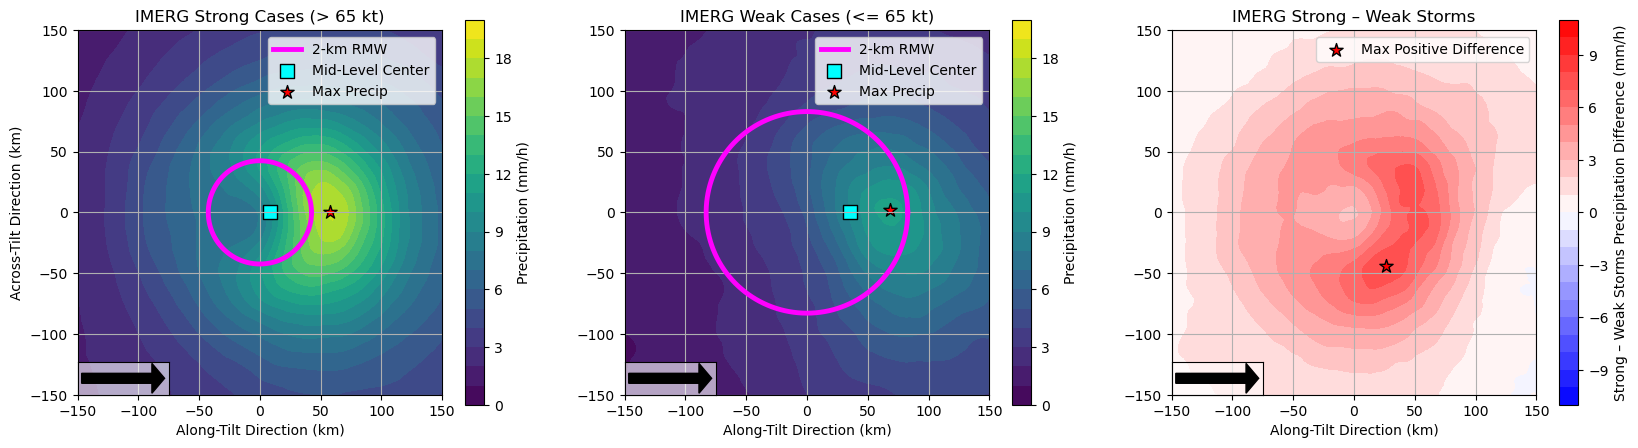

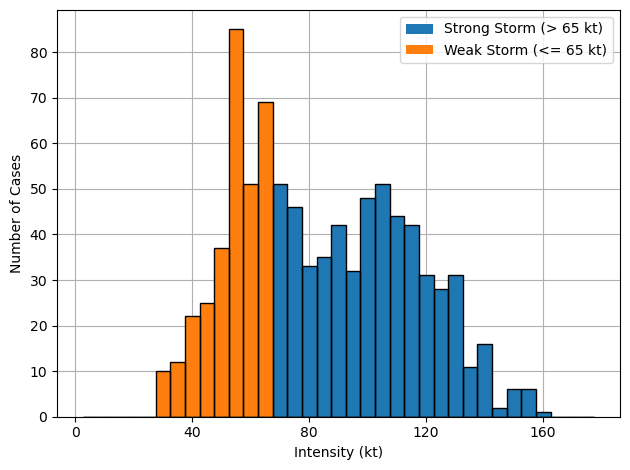

In [12]:
# Plot composites by intensity

strong_cases_imerg_mean = strong_cases_imerg.mean('case')
weak_cases_imerg_mean = weak_cases_imerg.mean('case')

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

# Identify mean MLCS
mean_weak_cases_mlcs_x = weak_cases_mlcs_x.mean()
mean_weak_cases_mlcs_y = weak_cases_mlcs_y.mean()
mean_strong_cases_mlcs_x = strong_cases_mlcs_x.mean()
mean_strong_cases_mlcs_y = strong_cases_mlcs_y.mean()

# Draw Circle

X,Y,THETA = circle([0,0],strong_cases_rmw.mean(),1000)

weak_cf = ax.contourf(strong_cases_imerg_mean['x'], strong_cases_imerg_mean['y'],strong_cases_imerg_mean,levels=np.arange(0,20.1,1))
plt.colorbar(weak_cf,label='Precipitation (mm/h)')
ax.grid()
ax.set_title('IMERG Strong Cases (> 65 kt)')
ax.set_xlabel('Along-Tilt Direction (km)')
ax.set_ylabel('Across-Tilt Direction (km)')
ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax.scatter(mean_strong_cases_mlcs_x,mean_strong_cases_mlcs_y,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_strong_cases = strong_cases_imerg_mean.argmax(dim=["x","y"])['x'].values
ind_2_max_strong_cases = strong_cases_imerg_mean.argmax(dim=["x","y"])['y'].values
actual_x_strong_cases = strong_cases_imerg_mean[ind_1_max_strong_cases,ind_2_max_strong_cases]['x']
actual_y_strong_cases = strong_cases_imerg_mean[ind_1_max_strong_cases,ind_2_max_strong_cases]['y']
ax.scatter(actual_x_strong_cases,actual_y_strong_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax.legend(loc=1)

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

X2,Y2,THETA2 = circle([0,0],weak_cases_rmw.mean(),1000)

cf2 = ax2.contourf(weak_cases_imerg_mean['x'], weak_cases_imerg_mean['y'],weak_cases_imerg_mean,levels=np.arange(0,20.1,1))
plt.colorbar(cf2,label='Precipitation (mm/h)')
ax2.grid()
ax2.set_title('IMERG Weak Cases (<= 65 kt)')
ax2.set_xlabel('Along-Tilt Direction (km)')
ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax2.scatter(mean_weak_cases_mlcs_x,mean_weak_cases_mlcs_y,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_weak_cases = weak_cases_imerg_mean.argmax(dim=["x","y"])['x'].values
ind_2_max_weak_cases = weak_cases_imerg_mean.argmax(dim=["x","y"])['y'].values
actual_x_weak_cases = weak_cases_imerg_mean[ind_1_max_weak_cases,ind_2_max_weak_cases]['x']
actual_y_weak_cases = weak_cases_imerg_mean[ind_1_max_weak_cases,ind_2_max_weak_cases]['y']
ax2.scatter(actual_x_weak_cases,actual_y_weak_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax2.legend(loc=1)

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ax_cf = ax3.contourf(strong_cases_imerg_mean['x'], strong_cases_imerg_mean['y'],strong_cases_imerg_mean-weak_cases_imerg_mean,
                     cmap='bwr',levels=np.arange(-11,11.1,1))
plt.colorbar(ax_cf,label='Strong – Weak Storms Precipitation Difference (mm/h)')
ax3.set_title('IMERG Strong – Weak Storms')
ax3.set_xlabel('Along-Tilt Direction (km)')
ax3.grid()
axins = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q3 = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)
ind_1_max_diff_cases = (strong_cases_imerg_mean-weak_cases_imerg_mean).argmax(dim=["x","y"])['x'].values
ind_2_max_diff_cases = (strong_cases_imerg_mean-weak_cases_imerg_mean).argmax(dim=["x","y"])['y'].values
actual_x_diff_cases = (strong_cases_imerg_mean-weak_cases_imerg_mean)[ind_1_max_diff_cases,ind_2_max_diff_cases]['x']
actual_y_diff_cases = (strong_cases_imerg_mean-weak_cases_imerg_mean)[ind_1_max_diff_cases,ind_2_max_diff_cases]['y']
ax3.scatter(actual_x_diff_cases,actual_y_diff_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Positive Difference')
ax3.legend(loc=1)

plt.figure()
axhist = plt.axes()
axhist.grid()
axhist.set_axisbelow(True)

axhist.hist(full_info_pd.loc[strong_indices]['Intensity'], histtype='bar',
         bins=np.arange(2.5,182.5,5),label='Strong Storm (> 65 kt)',rwidth=1)
axhist.hist(full_info_pd.loc[weak_indices]['Intensity'], histtype='bar',
         bins=np.arange(2.5,182.5,5),label='Weak Storm (<= 65 kt)',rwidth=1)
axhist.hist(full_info_pd.loc[strong_indices]['Intensity'],
         bins=np.arange(2.5,182.5,5),rwidth=1, fill=False)
axhist.hist(full_info_pd.loc[weak_indices]['Intensity'],
         bins=np.arange(2.5,182.5,5),rwidth=1, fill=False)

axhist.set_xticks(np.arange(0,180,40))
axhist.set_xlabel('Intensity (kt)')
axhist.set_ylabel('Number of Cases')
plt.legend()
plt.tight_layout()

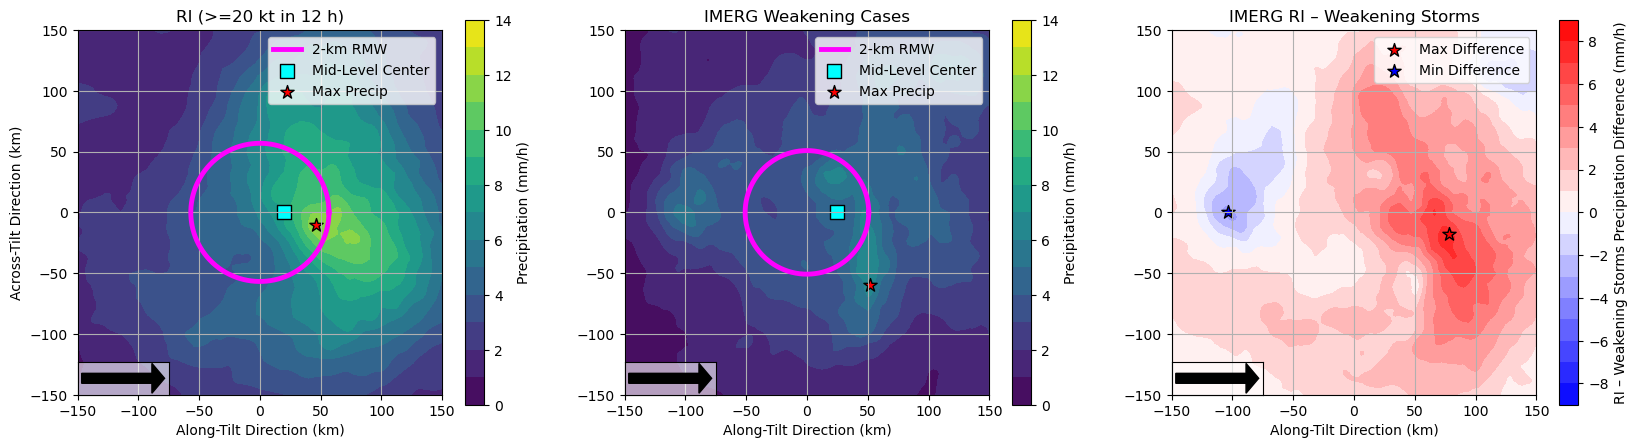

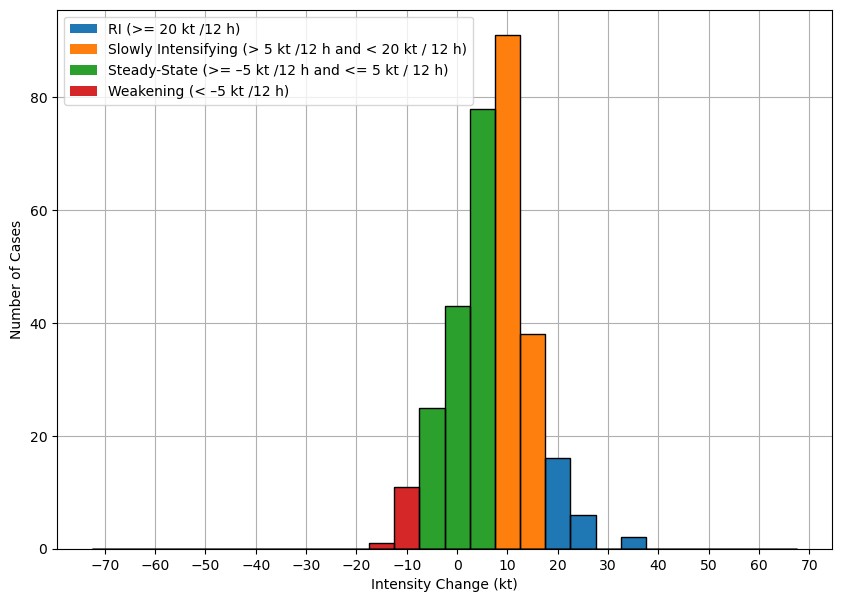

In [13]:
# Plot composites by intensity CHANGE

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

# Find mean MLCS Locations

# Identify mean MLC X and Y locations

mean_weakening_cases_mlcs_x = weakening_cases_mlcs_x.mean()
mean_weakening_cases_mlcs_y = weakening_cases_mlcs_y.mean()
mean_intensifying_cases_mlcs_x = intensifying_cases_mlcs_x.mean()
mean_intensifying_cases_mlcs_y = intensifying_cases_mlcs_y.mean()
mean_SS_cases_mlcs_x = SS_cases_mlcs_x.mean()
mean_SS_cases_mlcs_y = SS_cases_mlcs_y.mean()
mean_RI_cases_mlcs_x = RI_cases_mlcs_x.mean()
mean_RI_cases_mlcs_y = RI_cases_mlcs_y.mean()

# Draw Circle

X,Y,THETA = circle([0,0],RI_rmw.mean(),1000)

weak_cf = ax.contourf(RI_imerg_data['x'], RI_imerg_data['y'],RI_imerg_data.mean('case'),
                      levels=np.arange(0,14.1,1))
plt.colorbar(weak_cf,label='Precipitation (mm/h)')
ax.grid()
ax.set_title('RI (>=20 kt in 12 h)')
ax.set_xlabel('Along-Tilt Direction (km)')
ax.set_ylabel('Across-Tilt Direction (km)')
ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax.scatter(mean_RI_cases_mlcs_x,mean_RI_cases_mlcs_y,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')

ind_1_max_RI_cases = RI_imerg_data.mean('case').argmax(dim=["x","y"])['x'].values
ind_2_max_RI_cases = RI_imerg_data.mean('case').argmax(dim=["x","y"])['y'].values
actual_x_RI_cases = RI_imerg_data.mean('case')[ind_1_max_RI_cases,ind_2_max_RI_cases]['x']
actual_y_RI_cases = RI_imerg_data.mean('case')[ind_1_max_RI_cases,ind_2_max_RI_cases]['y']
ax.scatter(actual_x_RI_cases,actual_y_RI_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax.legend(loc=1)

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

intensity_change_choice = 'Weakening'

if intensity_change_choice == 'Weakening':
    X2,Y2,THETA2 = circle([0,0],Weakening_rmw.mean(),1000)
    data_choice = weakening_imerg_data
    mlc_x_choice = mean_weakening_cases_mlcs_x
    mlc_y_choice = mean_weakening_cases_mlcs_y
    
elif intensity_change_choice == 'Steady-State':
    X2,Y2,THETA2 = circle([0,0],SS_rmw.mean(),1000)
    data_choice = SS_imerg_data
    mlc_x_choice = mean_SS_cases_mlcs_x
    mlc_y_choice = mean_SS_cases_mlcs_y
elif intensity_change_choice == 'Slowly Intensifying':
    X2,Y2,THETA2 = circle([0,0],intensifying_rmw.mean(),1000)
    data_choice = intensifying_imerg_data
    mlc_x_choice = mean_intensifying_cases_mlcs_x
    mlc_y_choice = mean_intensifying_cases_mlcs_y

cf2 = ax2.contourf(data_choice['x'], data_choice['y'],data_choice.mean('case'),
                   levels=np.arange(0,14.1,1))
plt.colorbar(cf2,label='Precipitation (mm/h)')
ax2.grid()
ax2.set_title('IMERG ' + intensity_change_choice + ' Cases')
ax2.set_xlabel('Along-Tilt Direction (km)')
ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax2.scatter(mlc_x_choice,mlc_y_choice,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_choice_cases = data_choice.mean('case').argmax(dim=["x","y"])['x'].values
ind_2_max_choice_cases = data_choice.mean('case').argmax(dim=["x","y"])['y'].values
actual_x_choice_cases = data_choice.mean('case')[ind_1_max_choice_cases,ind_2_max_choice_cases]['x']
actual_y_choice_cases = data_choice.mean('case')[ind_1_max_choice_cases,ind_2_max_choice_cases]['y']
ax2.scatter(actual_x_choice_cases,actual_y_choice_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax2.legend(loc=1)

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ax_cf = ax3.contourf(RI_imerg_data['x'], RI_imerg_data['y'],RI_imerg_data.mean('case')-data_choice.mean('case'),
                     cmap='bwr',levels=np.arange(-9,9.1,1))
plt.colorbar(ax_cf,label='RI – ' +str(intensity_change_choice) +' Storms Precipitation Difference (mm/h)')
ax3.set_title('IMERG RI – ' +str(intensity_change_choice) +' Storms')
ax3.set_xlabel('Along-Tilt Direction (km)')
ax3.grid()
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ind_1_max_diff_choice_cases = (RI_imerg_data.mean('case')-data_choice.mean('case')).argmax(dim=["x","y"])['x'].values
ind_2_max_diff_choice_cases = (RI_imerg_data.mean('case')-data_choice.mean('case')).argmax(dim=["x","y"])['y'].values
actual_x_max_diff_cases = (RI_imerg_data.mean('case')-data_choice.mean('case'))[ind_1_max_diff_choice_cases,ind_2_max_diff_choice_cases]['x']
actual_y_max_diff_cases = (RI_imerg_data.mean('case')-data_choice.mean('case'))[ind_1_max_diff_choice_cases,ind_2_max_diff_choice_cases]['y']
ax3.scatter(actual_x_max_diff_cases,actual_y_max_diff_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Difference')

ind_1_min_diff_choice_cases = (RI_imerg_data.mean('case')-data_choice.mean('case')).argmin(dim=["x","y"])['x'].values
ind_2_min_diff_choice_cases = (RI_imerg_data.mean('case')-data_choice.mean('case')).argmin(dim=["x","y"])['y'].values
actual_x_min_diff_cases = (RI_imerg_data.mean('case')-data_choice.mean('case'))[ind_1_min_diff_choice_cases,ind_2_min_diff_choice_cases]['x']
actual_y_min_diff_cases = (RI_imerg_data.mean('case')-data_choice.mean('case'))[ind_1_min_diff_choice_cases,ind_2_min_diff_choice_cases]['y']
ax3.scatter(actual_x_min_diff_cases,actual_y_min_diff_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='blue',marker='*',label='Min Difference')
ax3.legend(loc=1)


plt.figure(figsize=(10,7))
axhist = plt.axes()
axhist.grid()
axhist.set_axisbelow(True)

axhist.hist(future_change.loc[RI_cases.index], histtype='bar',
         bins=np.arange(-72.5,72.5,5),label='RI (>= 20 kt /12 h)',rwidth=1)
axhist.hist(future_change.loc[Intensifying_cases.index], histtype='bar',
         bins=np.arange(-72.5,72.5,5),label='Slowly Intensifying (> 5 kt /12 h and < 20 kt / 12 h)',rwidth=1)
axhist.hist(future_change.loc[SS_cases.index], histtype='bar',
         bins=np.arange(-72.5,72.5,5),label='Steady-State (>= –5 kt /12 h and <= 5 kt / 12 h)',rwidth=1)
axhist.hist(future_change.loc[Weakening_cases.index], histtype='bar',
         bins=np.arange(-72.5,72.5,5),label='Weakening (< –5 kt /12 h)',rwidth=1)
axhist.hist(future_change.loc[RI_cases.index],
         bins=np.arange(-72.5,72.5,5),rwidth=1, fill=False)
axhist.hist(future_change.loc[Intensifying_cases.index],
         bins=np.arange(-72.5,72.5,5),rwidth=1, fill=False)
axhist.hist(future_change.loc[SS_cases.index],
         bins=np.arange(-72.5,72.5,5),rwidth=1, fill=False) 
axhist.hist(future_change.loc[Weakening_cases.index],
         bins=np.arange(-72.5,72.5,5),rwidth=1, fill=False) 
              
axhist.set_xticks(np.arange(-70,70.1,10))
axhist.set_xlabel('Intensity Change (kt)')
axhist.set_ylabel('Number of Cases')
plt.legend()

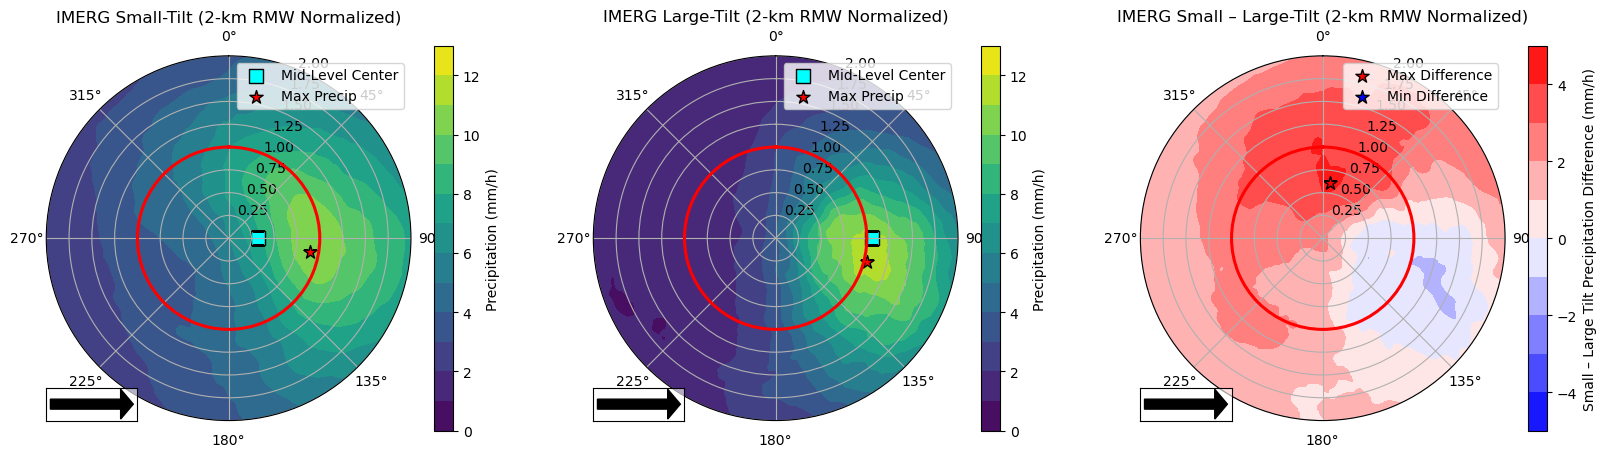

In [14]:
# Make polar RMW normalized plots

small_tilt_cylindrical_cases = all_cylindrical_xr.sel(case = small_tilt_indices)
large_tilt_cylindrical_cases = all_cylindrical_xr.sel(case = large_tilt_indices)


# Find MLC for RMW normalized plot

norm_large_tilt_mlc_r = (np.sqrt((large_tilt_mlcs_x**2)+(large_tilt_mlcs_y**2))/large_tilt_rmws).mean()
norm_large_tilt_mlc_ang = (90 * (np.pi/180)) - (np.arctan(large_tilt_mlcs_y.mean()/large_tilt_mlcs_x.mean()))

norm_small_tilt_mlc_r = (np.sqrt((small_tilt_mlcs_x**2)+(small_tilt_mlcs_y**2))/small_tilt_rmws).mean()
norm_small_tilt_mlc_ang = (90 * (np.pi/180)) - (np.arctan(small_tilt_mlcs_y.mean()/small_tilt_mlcs_x.mean()))

fig = plt.figure(figsize=(20, 5)) 
gs = fig.add_gridspec(1,3)

ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection='polar')
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection='polar')
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1,projection='polar')

ax.grid(True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
s_plot = ax.contourf(small_tilt_cylindrical_cases['azimuth'], small_tilt_cylindrical_cases['radius'],
                      small_tilt_cylindrical_cases.mean('case'),levels=np.arange(0,14,1))
ax.set_rlim(0,2)
ax.set_title('IMERG Small-Tilt (2-km RMW Normalized)')
ax.scatter(norm_small_tilt_mlc_ang,norm_small_tilt_mlc_r,s=100,linewidths = 1,edgecolors = 'k',
           color='cyan',marker='s',label='Mid-Level Center')
plt.colorbar(s_plot,label='Precipitation (mm/h)')

ax_gl = ax.get_ygridlines()
ax_b = ax_gl[3]
ax_b.set_color('red')
ax_b.set_linewidth(2.2)

ax.legend()

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ind_1_max_small_tilt_cyli_cases = small_tilt_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_small_tilt_cyli_cases = small_tilt_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_small_tilt_cyli_cases = small_tilt_cylindrical_cases.mean('case')[ind_1_max_small_tilt_cyli_cases,ind_2_max_small_tilt_cyli_cases]['azimuth']
actual_rad_small_tilt_cyli_cases = small_tilt_cylindrical_cases.mean('case')[ind_1_max_small_tilt_cyli_cases,ind_2_max_small_tilt_cyli_cases]['radius']
ax.scatter(actual_azi_small_tilt_cyli_cases,actual_rad_small_tilt_cyli_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax.legend(loc=1)

ax2.grid(True)
ax2.set_theta_direction(-1)
ax2.set_theta_zero_location('N')
l_plot = ax2.contourf(large_tilt_cylindrical_cases['azimuth'], large_tilt_cylindrical_cases['radius'],
                      large_tilt_cylindrical_cases.mean('case'),levels=np.arange(0,14,1))
ax2.set_rlim(0,2)
ax2.set_title('IMERG Large-Tilt (2-km RMW Normalized)')
ax2.scatter(norm_large_tilt_mlc_ang,norm_large_tilt_mlc_r,s=100,linewidths = 1,edgecolors = 'k',
           color='cyan',marker='s',label='Mid-Level Center')

plt.colorbar(l_plot,label='Precipitation (mm/h)')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ind_1_max_large_tilt_cyli_cases = large_tilt_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_large_tilt_cyli_cases = large_tilt_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_large_tilt_cyli_cases = large_tilt_cylindrical_cases.mean('case')[ind_1_max_large_tilt_cyli_cases,ind_2_max_large_tilt_cyli_cases]['azimuth']
actual_rad_large_tilt_cyli_cases = large_tilt_cylindrical_cases.mean('case')[ind_1_max_large_tilt_cyli_cases,ind_2_max_large_tilt_cyli_cases]['radius']
ax2.scatter(actual_azi_large_tilt_cyli_cases,actual_rad_large_tilt_cyli_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax2.legend(loc=1)

ax2_gl = ax2.get_ygridlines()
ax2_b = ax2_gl[3]
ax2_b.set_color('red')
ax2_b.set_linewidth(2.2)

ax3.grid(True)
ax3.set_theta_direction(-1)
ax3.set_theta_zero_location('N')
d_plot = ax3.contourf(small_tilt_cylindrical_cases['azimuth'], small_tilt_cylindrical_cases['radius'],
                      small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.mean('case')
                      ,cmap='bwr',levels=np.arange(-5,5.1,1))
ax3.set_rlim(0,2)
ax3.set_title('IMERG Small – Large-Tilt (2-km RMW Normalized)')

plt.colorbar(d_plot,label='Small – Large Tilt Precipitation Difference (mm/h)')

axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ind_1_max_diff_tilt_cyli_cases = (small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.mean(
    'case')).argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_diff_tilt_cyli_cases = (small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.
                                  mean('case')).argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_diff_tilt_cyli_cases = (small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.mean(
    'case'))[ind_1_max_diff_tilt_cyli_cases,ind_2_max_diff_tilt_cyli_cases]['azimuth']
actual_rad_diff_tilt_cyli_cases = (small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.mean('case')
                                  )[ind_1_max_diff_tilt_cyli_cases,ind_2_max_diff_tilt_cyli_cases]['radius']
ax3.scatter(actual_azi_diff_tilt_cyli_cases,actual_rad_diff_tilt_cyli_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Difference')

ind_1_min_diff_tilt_cyli_cases = (small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.mean(
    'case')).argmin(dim=["radius","azimuth"])['radius'].values
ind_2_min_diff_tilt_cyli_cases = (small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.
                                  mean('case')).argmin(dim=["radius","azimuth"])['azimuth'].values
actual_azi_min_diff_tilt_cyli_cases = (small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.mean(
    'case'))[ind_1_min_diff_tilt_cyli_cases,ind_2_min_diff_tilt_cyli_cases]['azimuth']
actual_rad_min_diff_tilt_cyli_cases = (small_tilt_cylindrical_cases.mean('case') - large_tilt_cylindrical_cases.mean('case')
                                  )[ind_1_min_diff_tilt_cyli_cases,ind_2_min_diff_tilt_cyli_cases]['radius']
ax3.scatter(actual_azi_min_diff_tilt_cyli_cases,actual_rad_min_diff_tilt_cyli_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='blue',marker='*',label='Min Difference')
ax3_gl = ax3.get_ygridlines()
ax3_b = ax3_gl[3]
ax3_b.set_color('red')
ax3_b.set_linewidth(2.2)

ax3.legend(loc=1)

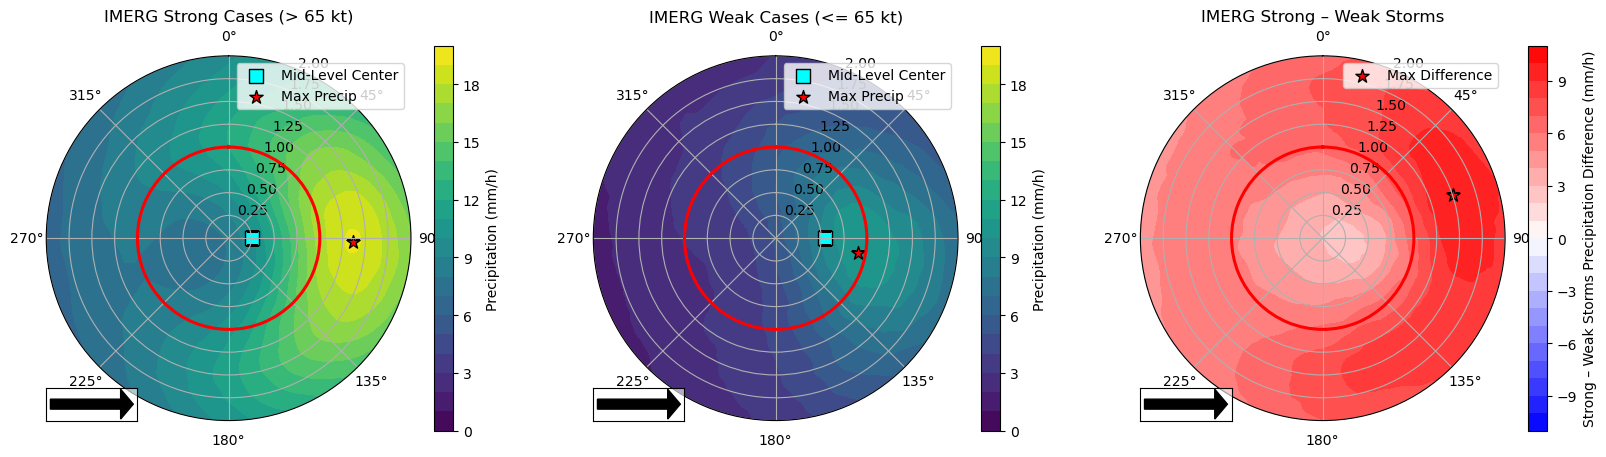

In [15]:
# Plot composites by intensity but for polar plot rmw normalized plot!

strong_storms_cylindrical_cases = all_cylindrical_xr.sel(case = strong_indices)
weak_storms_cylindrical_cases = all_cylindrical_xr.sel(case = weak_indices)


fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection='polar')
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection='polar')
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1,projection='polar')

# # Identify mean MLCS

# Find MLC for RMW normalized plot

norm_strong_case_mlc_r = (np.sqrt((strong_cases_mlcs_x**2)+(strong_cases_mlcs_y**2))/strong_cases_rmw).mean()
norm_strong_case_mlc_ang = (90 * (np.pi/180)) - (np.arctan(strong_cases_mlcs_y.mean()/strong_cases_mlcs_x.mean()))

norm_weak_case_mlc_r = (np.sqrt((weak_cases_mlcs_x**2)+(weak_cases_mlcs_y**2))/weak_cases_rmw).mean()
norm_weak_case_mlc_ang = (90 * (np.pi/180)) - (np.arctan(weak_cases_mlcs_y.mean()/weak_cases_mlcs_x.mean()))


ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')

ax_gl = ax.get_ygridlines()
ax_b = ax_gl[3]
ax_b.set_color('red')
ax_b.set_linewidth(2.2)
strong_cf = ax.contourf(strong_storms_cylindrical_cases['azimuth'], strong_storms_cylindrical_cases['radius'],
                        strong_storms_cylindrical_cases.mean('case'),levels=np.arange(0,20.1,1))
plt.colorbar(strong_cf,label='Precipitation (mm/h)')
ax.grid(True)
ax.set_title('IMERG Strong Cases (> 65 kt)')
ax.scatter(norm_strong_case_mlc_ang,norm_strong_case_mlc_r,s=100,linewidths = 1,edgecolors = 'k',
           color='cyan',marker='s',label='Mid-Level Center')

ind_1_max_strong_storms_cyli_cases = strong_storms_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_strong_storms_cyli_cases = strong_storms_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_strong_storms_cyli_cases = strong_storms_cylindrical_cases.mean('case')[ind_1_max_strong_storms_cyli_cases,ind_2_max_strong_storms_cyli_cases]['azimuth']
actual_rad_strong_storms_cyli_cases = strong_storms_cylindrical_cases.mean('case')[ind_1_max_strong_storms_cyli_cases,ind_2_max_strong_storms_cyli_cases]['radius']
ax.scatter(actual_azi_strong_storms_cyli_cases,actual_rad_strong_storms_cyli_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax.legend(loc=1)

ax.set_rlim(0,2)
axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

cf2 = ax2.contourf(weak_storms_cylindrical_cases['azimuth'], weak_storms_cylindrical_cases['radius'],
                        weak_storms_cylindrical_cases.mean('case'),levels=np.arange(0,20.1,1))

plt.colorbar(cf2,label='Precipitation (mm/h)')
ax2.grid(True)
ax2.set_theta_direction(-1)
ax2.set_theta_zero_location('N')
ax2.set_title('IMERG Weak Cases (<= 65 kt)')
ax2.scatter(norm_weak_case_mlc_ang,norm_weak_case_mlc_r,s=100,linewidths = 1,
            edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')

ind_1_max_weak_storms_cyli_cases = weak_storms_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_weak_storms_cyli_cases = weak_storms_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_weak_storms_cyli_cases = weak_storms_cylindrical_cases.mean('case')[ind_1_max_weak_storms_cyli_cases,ind_2_max_weak_storms_cyli_cases]['azimuth']
actual_rad_weak_storms_cyli_cases = weak_storms_cylindrical_cases.mean('case')[ind_1_max_weak_storms_cyli_cases,ind_2_max_weak_storms_cyli_cases]['radius']
ax2.scatter(actual_azi_weak_storms_cyli_cases,actual_rad_weak_storms_cyli_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax2.legend(loc=1)

ax2.set_rlim(0,2)
axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ax2_gl = ax2.get_ygridlines()
ax2_b = ax2_gl[3]
ax2_b.set_color('red')
ax2_b.set_linewidth(2.2)

ax_cf = ax3.contourf(strong_storms_cylindrical_cases['azimuth'], strong_storms_cylindrical_cases['radius'],
                        strong_storms_cylindrical_cases.mean('case') - weak_storms_cylindrical_cases.mean('case'),
                    cmap='bwr',levels=np.arange(-11,11.5,1))
plt.colorbar(ax_cf,label='Strong – Weak Storms Precipitation Difference (mm/h)')
ax3.set_title('IMERG Strong – Weak Storms')
ax3.grid(True)
ax3.set_theta_direction(-1)
ax3.set_theta_zero_location('N')
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)
ax3.set_rlim(0,2)

ind_1_max_diff_strong_weak_cyli_cases = (strong_storms_cylindrical_cases.
                                         mean('case') - weak_storms_cylindrical_cases.mean('case')).argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_diff_strong_weak_cyli_cases = (strong_storms_cylindrical_cases.
                                  mean('case') - weak_storms_cylindrical_cases.mean('case')).argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_diff_strong_weak_cyli_cases = (strong_storms_cylindrical_cases.
                                         mean('case') - weak_storms_cylindrical_cases.mean('case'))[ind_1_max_diff_strong_weak_cyli_cases,ind_2_max_diff_strong_weak_cyli_cases]['azimuth']
actual_rad_diff_strong_weak_cyli_cases = (strong_storms_cylindrical_cases.
                                         mean('case') - weak_storms_cylindrical_cases.mean('case'))[ind_1_max_diff_strong_weak_cyli_cases,ind_2_max_diff_strong_weak_cyli_cases]['radius']
ax3.scatter(actual_azi_diff_strong_weak_cyli_cases,actual_rad_diff_strong_weak_cyli_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Difference')

ax3_gl = ax3.get_ygridlines()
ax3_b = ax3_gl[3]
ax3_b.set_color('red')
ax3_b.set_linewidth(2.2)
ax3.legend(loc=1)

RI Stats : 6.974445110407064 6.819681538902997 1.0226936654770777
Inside RMW Std: 1.8749978502316935
Outside RMW Std: 2.7526180072235484
Slowly Intensifying Stats : 6.003706447274652 5.1723101449240625 1.1607398394635122
Inside RMW Std: 2.2448375252081463
Outside RMW Std: 2.999249796708745


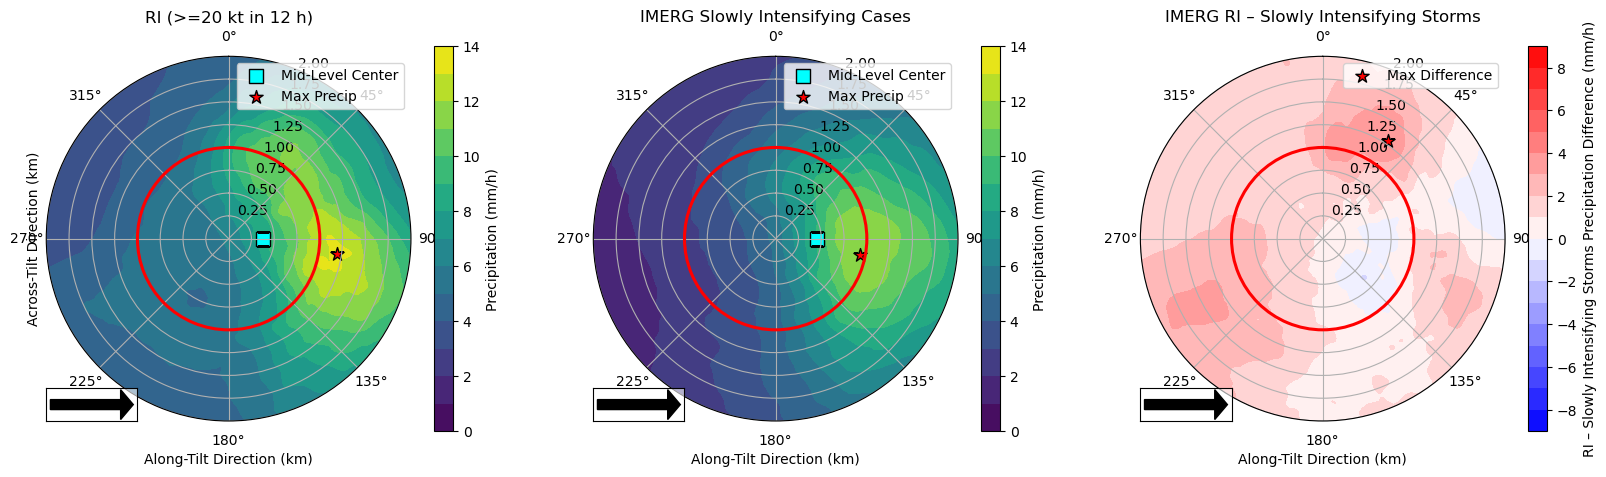

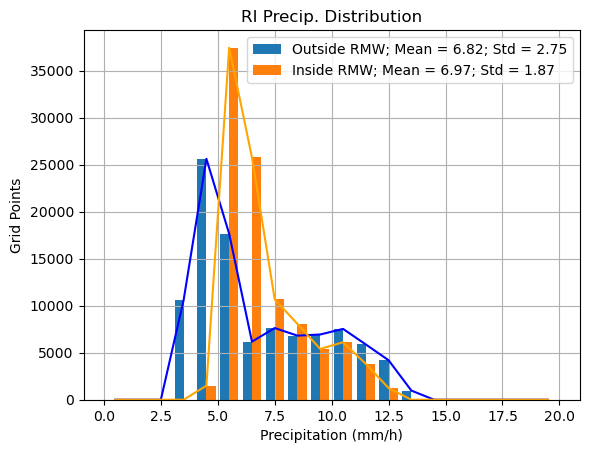

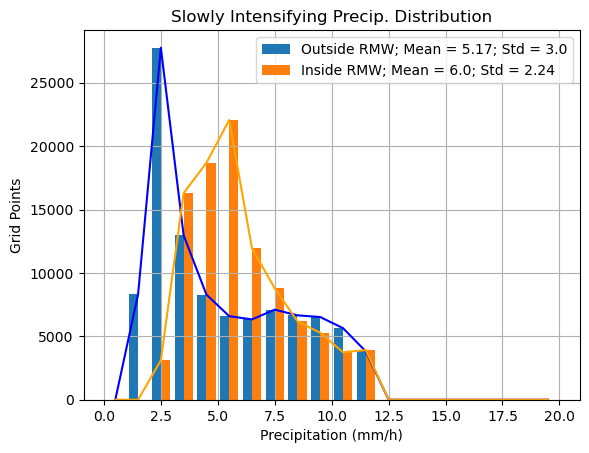

In [16]:
# Create Intensity change with polar RMW Normalization

# Plot composites by intensity CHANGE

RI_cylindrical_cases = all_cylindrical_xr.sel(case = RI_cases.index)

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection='polar')
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection='polar')
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1,projection='polar')

# Find mean MLCS Locations

# Identify mean MLC X and Y locations

# mean_weakening_cases_mlcs_x = weakening_cases_mlcs_x.mean()
# mean_weakening_cases_mlcs_y = weakening_cases_mlcs_y.mean()
# mean_intensifying_cases_mlcs_x = intensifying_cases_mlcs_x.mean()
# mean_intensifying_cases_mlcs_y = intensifying_cases_mlcs_y.mean()
# mean_SS_cases_mlcs_x = SS_cases_mlcs_x.mean()
# mean_SS_cases_mlcs_y = SS_cases_mlcs_y.mean()
# mean_RI_cases_mlcs_x = RI_cases_mlcs_x.mean()
# mean_RI_cases_mlcs_y = RI_cases_mlcs_y.mean()

# Find MLC for RMW normalized plot

norm_RI_mlc_r = (np.sqrt((RI_cases_mlcs_x**2)+(RI_cases_mlcs_y**2))/RI_rmw).mean()
norm_RI_mlc_ang = (90 * (np.pi/180)) - (np.arctan(RI_cases_mlcs_y.mean()/RI_cases_mlcs_x.mean()))

ax.grid(True)
ax.set_rlim(0,2)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')

weak_cf = ax.contourf(RI_cylindrical_cases['azimuth'], RI_cylindrical_cases['radius'],RI_cylindrical_cases.mean('case'),
                      levels=np.arange(0,14.1,1))
plt.colorbar(weak_cf,label='Precipitation (mm/h)')
ax.grid()
ax.set_title('RI (>=20 kt in 12 h)')
ax.set_xlabel('Along-Tilt Direction (km)')
ax.set_ylabel('Across-Tilt Direction (km)')
ax.scatter(norm_RI_mlc_ang,norm_RI_mlc_r,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_RI_cylindrical_cases = RI_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_RI_cylindrical_cases = RI_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_RI_cylindrical_cases = RI_cylindrical_cases.mean('case')[ind_1_max_RI_cylindrical_cases,ind_2_max_RI_cylindrical_cases]['azimuth']
actual_rad_RI_cylindrical_cases = RI_cylindrical_cases.mean('case')[ind_1_max_RI_cylindrical_cases,ind_2_max_RI_cylindrical_cases]['radius']

ax.scatter(actual_azi_RI_cylindrical_cases,actual_rad_RI_cylindrical_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax.legend(loc=1)

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
ax.grid(True)

ax_gl = ax.get_ygridlines()
ax_b = ax_gl[3]
ax_b.set_color('red')
ax_b.set_linewidth(2.2)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

intensity_change_choice = 'Slowly Intensifying'

if intensity_change_choice == 'Weakening':
    data_choice = weakening_imerg_data
    mlc_x_choice = weakening_cases_mlcs_x
    mlc_y_choice = weakening_cases_mlcs_y
    choice_rmw = Weakening_rmw
    choice_index = Weakening_cases.index

elif intensity_change_choice == 'Steady-State':
    data_choice = SS_imerg_data
    mlc_x_choice = SS_cases_mlcs_x
    mlc_y_choice = SS_cases_mlcs_y
    choice_rmw = SS_rmw
    choice_index = SS_cases.index

elif intensity_change_choice == 'Slowly Intensifying':
    data_choice = intensifying_imerg_data
    mlc_x_choice = intensifying_cases_mlcs_x
    mlc_y_choice = intensifying_cases_mlcs_y
    choice_rmw = intensifying_rmw
    choice_index = Intensifying_cases.index

# Find choice case r and angle location for MLC in polar plot
norm_choice_mlc_r = (np.sqrt((mlc_x_choice**2)+(mlc_y_choice**2))/choice_rmw).mean()
norm_choice_case_mlc_ang = (90 * (np.pi/180)) - (np.arctan(mlc_y_choice.mean()/mlc_x_choice.mean()))

choice_storms_cylindrical_cases = all_cylindrical_xr.sel(case = choice_index)

ax2.grid(True)
ax2.set_rlim(0,2)


ax2_gl = ax2.get_ygridlines()
ax2_b = ax2_gl[3]
ax2_b.set_color('red')
ax2_b.set_linewidth(2.2)
ax2.set_theta_direction(-1)
ax2.set_theta_zero_location('N')


cf2 = ax2.contourf(choice_storms_cylindrical_cases['azimuth'], choice_storms_cylindrical_cases['radius'],
                   choice_storms_cylindrical_cases.mean('case'),
                   levels=np.arange(0,14.1,1))
plt.colorbar(cf2,label='Precipitation (mm/h)')
ax2.set_title('IMERG ' + intensity_change_choice + ' Cases')
ax2.set_xlabel('Along-Tilt Direction (km)')
ax2.scatter(norm_choice_case_mlc_ang,norm_choice_mlc_r,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_choice_cylindrical_cases = choice_storms_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_choice_cylindrical_cases = choice_storms_cylindrical_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_choice_cylindrical_cases = choice_storms_cylindrical_cases.mean('case')[ind_1_max_choice_cylindrical_cases,ind_2_max_choice_cylindrical_cases]['azimuth']
actual_rad_choice_cylindrical_cases = choice_storms_cylindrical_cases.mean('case')[ind_1_max_choice_cylindrical_cases,ind_2_max_choice_cylindrical_cases]['radius']

ax2.scatter(actual_azi_choice_cylindrical_cases,actual_rad_choice_cylindrical_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax2.legend(loc=1)

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ax_cf = ax3.contourf(choice_storms_cylindrical_cases['azimuth'],
                     choice_storms_cylindrical_cases['radius'],
                     (RI_cylindrical_cases.mean('case') - choice_storms_cylindrical_cases.mean('case')),
                     cmap='bwr',levels=np.arange(-9,9.1,1))
plt.colorbar(ax_cf,label='RI – ' +str(intensity_change_choice) +' Storms Precipitation Difference (mm/h)')
ax3.set_title('IMERG RI – ' +str(intensity_change_choice) +' Storms')
ax3.set_xlabel('Along-Tilt Direction (km)')
ax3.grid(True)
ax3.set_rlim(0,2)
ax3_gl = ax3.get_ygridlines()
ax3_b = ax3_gl[3]
ax3_b.set_color('red')
ax3_b.set_linewidth(2.2)
ax3.set_theta_direction(-1)
ax3.set_theta_zero_location('N')
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

ind_1_max_diff_cylindrical_cases = (RI_cylindrical_cases.mean('case') - choice_storms_cylindrical_cases.mean('case')
                                   ).argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_diff_cylindrical_cases = (RI_cylindrical_cases.mean('case') - choice_storms_cylindrical_cases.
                                    mean('case')).argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_diff_cylindrical_cases = (RI_cylindrical_cases.mean('case') - choice_storms_cylindrical_cases.
                                     mean('case'))[ind_1_max_diff_cylindrical_cases,ind_2_max_diff_cylindrical_cases]['azimuth']
actual_rad_diff_cylindrical_cases = (RI_cylindrical_cases.mean('case') - choice_storms_cylindrical_cases.
                                     mean('case'))[ind_1_max_diff_cylindrical_cases,ind_2_max_diff_cylindrical_cases]['radius']

ax3.scatter(actual_azi_diff_cylindrical_cases,actual_rad_diff_cylindrical_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Difference')

# ind_1_min_diff_choice_cases = (RI_imerg_data.mean('case')-data_choice.mean('case')).argmin(dim=["x","y"])['x'].values
# ind_2_min_diff_choice_cases = (RI_imerg_data.mean('case')-data_choice.mean('case')).argmin(dim=["x","y"])['y'].values
# actual_x_min_diff_cases = (RI_imerg_data.mean('case')-data_choice.mean('case'))[ind_1_min_diff_choice_cases,ind_2_min_diff_choice_cases]['x']
# actual_y_min_diff_cases = (RI_imerg_data.mean('case')-data_choice.mean('case'))[ind_1_min_diff_choice_cases,ind_2_min_diff_choice_cases]['y']
# ax3.scatter(actual_x_min_diff_cases,actual_y_min_diff_cases,s=100,linewidths = 1,
#             edgecolors = 'k',color='blue',marker='*',label='Min Difference')
ax3.legend(loc=1)

RI_inside_rmw = RI_cylindrical_cases.mean('case').where(
    RI_cylindrical_cases.mean('case')['radius'] < 1).values.flatten()

RI_outside_rmw = RI_cylindrical_cases.mean('case').where((
    RI_cylindrical_cases.mean('case')['radius'] >= 1) & 
    (RI_cylindrical_cases.mean('case')['radius'] < 2)).values.flatten()

plt.figure()
n1, x1, _1 = plt.hist([RI_outside_rmw,RI_inside_rmw],
                      bins=np.arange(0,20.1,1),
                      label=['Outside RMW; Mean = ' + str(round(np.nanmean(RI_outside_rmw),2))+'; Std = '+
                             str(round(np.nanstd(RI_outside_rmw),2)),'Inside RMW; Mean = ' + 
                             str(round(np.nanmean(RI_inside_rmw),2))+'; Std = '+
                             str(round(np.nanstd(RI_inside_rmw),2))])
bin_centers_1 = 0.5*(x1[1:]+x1[:-1])
plt.plot(bin_centers_1,n1[0],color='blue') ## using bin_centers rather than edges
plt.plot(bin_centers_1,n1[1],color='orange') ## using bin_centers rather than edges
plt.grid()
plt.legend(loc=1)
plt.xlabel('Precipitation (mm/h)')
plt.ylabel('Grid Points')
plt.title('RI Precip. Distribution')
print('RI Stats :',
      np.nanmean(RI_inside_rmw),
      np.nanmean(RI_outside_rmw),
      np.nanmean(RI_inside_rmw)/np.nanmean(RI_outside_rmw))
print('Inside RMW Std: ' + str(np.nanstd(RI_inside_rmw)))
print('Outside RMW Std: ' + str(np.nanstd(RI_outside_rmw)))

choice_inside_rmw = choice_storms_cylindrical_cases.mean('case').where(
    choice_storms_cylindrical_cases.mean('case')['radius'] < 1).values.flatten()

choice_outside_rmw = choice_storms_cylindrical_cases.mean('case').where((
    choice_storms_cylindrical_cases.mean('case')['radius'] >= 1) & 
    (choice_storms_cylindrical_cases.mean('case')['radius'] < 2)).values.flatten()

plt.figure()
n2, x2, _2 = plt.hist([choice_outside_rmw,choice_inside_rmw],
                      bins=np.arange(0,20.1,1),
                      label=['Outside RMW; Mean = ' + str(round(np.nanmean(choice_outside_rmw),2))+'; Std = '+
                             str(round(np.nanstd(choice_outside_rmw),2)),'Inside RMW; Mean = ' + 
                             str(round(np.nanmean(choice_inside_rmw),2))+'; Std = '+
                             str(round(np.nanstd(choice_inside_rmw),2))])
bin_centers_2 = 0.5*(x2[1:]+x2[:-1])
plt.plot(bin_centers_2,n2[0],color='blue') ## using bin_centers rather than edges
plt.plot(bin_centers_2,n2[1],color='orange') ## using bin_centers rather than edges
plt.grid()
plt.legend()
plt.xlabel('Precipitation (mm/h)')
plt.ylabel('Grid Points')
plt.title(intensity_change_choice+' Precip. Distribution')
print(intensity_change_choice+' Stats :',
      np.nanmean(choice_inside_rmw),np.nanmean(choice_outside_rmw),
      np.nanmean(choice_inside_rmw)/np.nanmean(choice_outside_rmw))
print('Inside RMW Std: ' + str(np.nanstd(choice_inside_rmw)))
print('Outside RMW Std: ' + str(np.nanstd(choice_outside_rmw)))

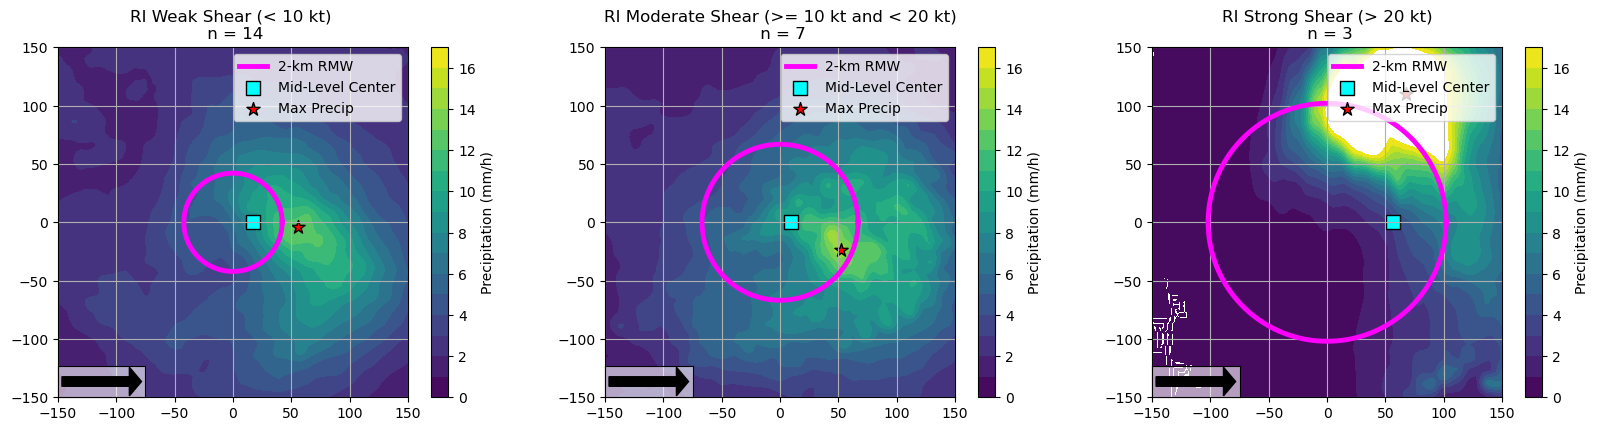

In [18]:
# Make three panel plot of RI at different shear (physical space; this may have a weak storm filter on it from above!)

RI_cases_weak_shear = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna()
RI_cases_moderate_shear = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
RI_cases_strong_shear = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()

X,Y,THETA = circle([0,0],full_info_pd.loc[RI_cases_weak_shear.index]['RMW'].mean(),1000)
X2,Y2,THETA = circle([0,0],full_info_pd.loc[RI_cases_moderate_shear.index]['RMW'].mean(),1000)
X3,Y3,THETA = circle([0,0],full_info_pd.loc[RI_cases_strong_shear.index]['RMW'].mean(),1000)

fig = plt.figure(figsize=(20, 10)) 
# plt.tight_layout()
gs = fig.add_gridspec(2,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

ax.grid(True)
ax.set_ylim(-150,150)
ax.set_xlim(-150,150)

ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')

RI_physical_weak_shear_cases = all_last_slices_xr.sel(case = RI_cases_weak_shear.index)

ax.set_title('RI Weak Shear (< 10 kt) \n n = ' + str(len(RI_physical_weak_shear_cases)))

weak_shear_RI_cf = ax.contourf(RI_physical_weak_shear_cases['x'],
            RI_physical_weak_shear_cases['y'],
            RI_physical_weak_shear_cases.mean('case'),levels=np.arange(0,17.1,1))
plt.colorbar(weak_shear_RI_cf,label='Precipitation (mm/h)')

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
ax.grid(True)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# Find MLC for RMW normalized plot

RI_weak_shear_cases_mlcs_x = full_info_pd.loc[RI_cases_weak_shear.index]['MLC X']
RI_weak_shear_cases_mlcs_y = full_info_pd.loc[RI_cases_weak_shear.index]['MLC Y']


ax.scatter(RI_weak_shear_cases_mlcs_x.mean(),RI_weak_shear_cases_mlcs_y.mean(),
           s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_RI_weak_shear_physical_cases = RI_physical_weak_shear_cases.mean('case').argmax(dim=["x","y"])['x'].values
ind_2_max_RI_weak_shear_physical_cases = RI_physical_weak_shear_cases.mean('case').argmax(dim=["x","y"])['y'].values
actual_x_RI_weak_shear_physical_cases = RI_physical_weak_shear_cases.mean('case')[ind_1_max_RI_weak_shear_physical_cases,ind_2_max_RI_weak_shear_physical_cases]['x']
actual_y_RI_weak_shear_physical_cases = RI_physical_weak_shear_cases.mean('case')[ind_1_max_RI_weak_shear_physical_cases,ind_2_max_RI_weak_shear_physical_cases]['y']

ax.scatter(actual_x_RI_weak_shear_physical_cases,actual_y_RI_weak_shear_physical_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax.legend(loc=1)

#-------------------------
ax2.grid(True)
ax2.set_ylim(-150,150)
ax2.set_xlim(-150,150)

ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')

RI_physical_moderate_shear_cases = all_last_slices_xr.sel(case = RI_cases_moderate_shear.index)

ax2.set_title('RI Moderate Shear (>= 10 kt and < 20 kt)\n n = ' + str(len(RI_physical_moderate_shear_cases)) )

moderate_shear_RI_cf = ax2.contourf(RI_physical_moderate_shear_cases['x'],
            RI_physical_moderate_shear_cases['y'],
            RI_physical_moderate_shear_cases.mean('case'),levels=np.arange(0,17.1,1))
plt.colorbar(moderate_shear_RI_cf,label='Precipitation (mm/h)')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
ax2.grid(True)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# Find MLC for RMW normalized plot

RI_moderate_shear_cases_mlcs_x = full_info_pd.loc[RI_cases_moderate_shear.index]['MLC X']
RI_moderate_shear_cases_mlcs_y = full_info_pd.loc[RI_cases_moderate_shear.index]['MLC Y']


ax2.scatter(RI_moderate_shear_cases_mlcs_x.mean(),RI_moderate_shear_cases_mlcs_y.mean(),
           s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_RI_moderate_shear_physical_cases = RI_physical_moderate_shear_cases.mean('case').argmax(dim=["x","y"])['x'].values
ind_2_max_RI_moderate_shear_physical_cases = RI_physical_moderate_shear_cases.mean('case').argmax(dim=["x","y"])['y'].values
actual_x_RI_moderate_shear_physical_cases = RI_physical_moderate_shear_cases.mean('case')[ind_1_max_RI_moderate_shear_physical_cases,ind_2_max_RI_moderate_shear_physical_cases]['x']
actual_y_RI_moderate_shear_physical_cases = RI_physical_moderate_shear_cases.mean('case')[ind_1_max_RI_moderate_shear_physical_cases,ind_2_max_RI_moderate_shear_physical_cases]['y']

ax2.scatter(actual_x_RI_moderate_shear_physical_cases,actual_y_RI_moderate_shear_physical_cases,
            s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax2.legend(loc=1)

# -------------------------
ax3.grid(True)
ax3.set_ylim(-150,150)
ax3.set_xlim(-150,150)

ax3.plot(X3,Y3,'magenta',lw=3.5,label = str(height)+'-km RMW')

RI_physical_strong_shear_cases = all_last_slices_xr.sel(case = RI_cases_strong_shear.index)

ax3.set_title('RI Strong Shear (> 20 kt)\n n = ' + str(len(RI_physical_strong_shear_cases)) )

strong_shear_RI_cf = ax3.contourf(RI_physical_strong_shear_cases['x'],
            RI_physical_strong_shear_cases['y'],
            RI_physical_strong_shear_cases.mean('case'),levels=np.arange(0,17.1,1))
plt.colorbar(strong_shear_RI_cf,label='Precipitation (mm/h)')

axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
ax3.grid(True)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# Find MLC for RMW normalized plot

RI_strong_shear_cases_mlcs_x = full_info_pd.loc[RI_cases_strong_shear.index]['MLC X']
RI_strong_shear_cases_mlcs_y = full_info_pd.loc[RI_cases_strong_shear.index]['MLC Y']


ax3.scatter(RI_strong_shear_cases_mlcs_x.mean(),RI_strong_shear_cases_mlcs_y.mean(),
           s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_RI_strong_shear_physical_cases = RI_physical_strong_shear_cases.mean('case').argmax(dim=["x","y"])['x'].values
ind_2_max_RI_strong_shear_physical_cases = RI_physical_strong_shear_cases.mean('case').argmax(dim=["x","y"])['y'].values
actual_x_RI_strong_shear_physical_cases = RI_physical_strong_shear_cases.mean('case')[ind_1_max_RI_strong_shear_physical_cases,ind_2_max_RI_strong_shear_physical_cases]['x']
actual_y_RI_strong_shear_physical_cases = RI_physical_strong_shear_cases.mean('case')[ind_1_max_RI_strong_shear_physical_cases,ind_2_max_RI_strong_shear_physical_cases]['y']

ax3.scatter(actual_x_RI_strong_shear_physical_cases,actual_y_RI_strong_shear_physical_cases,
            s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax3.legend(loc=1)

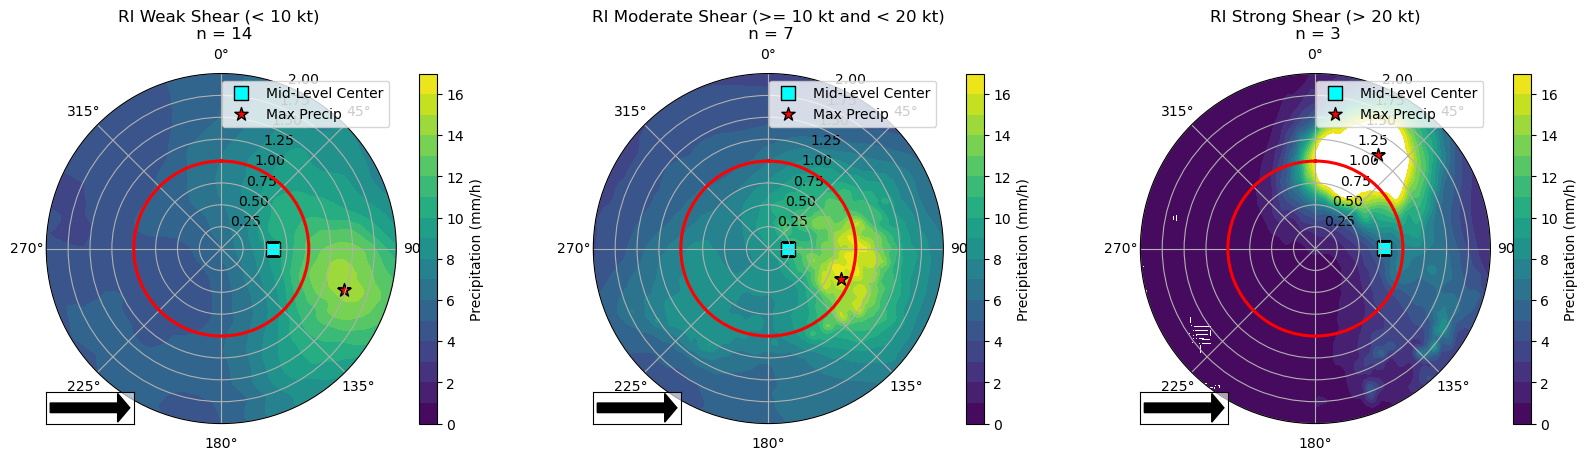

In [19]:
# Make three panel plot of RI at different shear (this may have a weak storm filter on it from above!)

RI_cases_weak_shear = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna()
RI_cases_moderate_shear = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
RI_cases_strong_shear = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()

fig = plt.figure(figsize=(20, 10)) 
# plt.tight_layout()
gs = fig.add_gridspec(2,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection='polar')
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection='polar')
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1,projection='polar')

ax.grid(True)
ax.set_rlim(0,2)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
RI_cylindrical_weak_shear_cases = all_cylindrical_xr.sel(case = RI_cases_weak_shear.index)

ax.set_title('RI Weak Shear (< 10 kt) \n n = ' + str(len(RI_cylindrical_weak_shear_cases)))

weak_shear_RI_cf = ax.contourf(RI_cylindrical_weak_shear_cases['azimuth'],
            RI_cylindrical_weak_shear_cases['radius'],
            RI_cylindrical_weak_shear_cases.mean('case'),levels=np.arange(0,17.1,1))
plt.colorbar(weak_shear_RI_cf,label='Precipitation (mm/h)')

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
ax.grid(True)

ax_gl = ax.get_ygridlines()
ax_b = ax_gl[3]
ax_b.set_color('red')
ax_b.set_linewidth(2.2)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# Find MLC for RMW normalized plot

RI_weak_shear_cases_mlcs_x = full_info_pd.loc[RI_cases_weak_shear.index]['MLC X']
RI_weak_shear_cases_mlcs_y = full_info_pd.loc[RI_cases_weak_shear.index]['MLC Y']

RI_weak_shear_rmw = full_info_pd.loc[RI_cases_weak_shear.index]['RMW']

norm_RI_weak_shear_mlc_r = (np.sqrt((RI_weak_shear_cases_mlcs_x**2)+(RI_weak_shear_cases_mlcs_x**2))/RI_weak_shear_rmw).mean()
norm_RI_weak_shear_mlc_ang = (90 * (np.pi/180)) - (np.arctan(RI_weak_shear_cases_mlcs_y.mean()/RI_weak_shear_cases_mlcs_x.mean()))


ax.scatter(norm_RI_weak_shear_mlc_ang,norm_RI_weak_shear_mlc_r,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_RI_weak_shear_cylindrical_cases = RI_cylindrical_weak_shear_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_RI_weak_shear_cylindrical_cases = RI_cylindrical_weak_shear_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_RI_weak_shear_cylindrical_cases = RI_cylindrical_weak_shear_cases.mean('case')[ind_1_max_RI_weak_shear_cylindrical_cases,ind_2_max_RI_weak_shear_cylindrical_cases]['azimuth']
actual_rad_RI_weak_shear_cylindrical_cases = RI_cylindrical_weak_shear_cases.mean('case')[ind_1_max_RI_weak_shear_cylindrical_cases,ind_2_max_RI_weak_shear_cylindrical_cases]['radius']

ax.scatter(actual_azi_RI_weak_shear_cylindrical_cases,actual_rad_RI_weak_shear_cylindrical_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax.legend(loc=1)

# -------------------------
ax2.grid(True)
ax2.set_rlim(0,2)
ax2.set_theta_direction(-1)
ax2.set_theta_zero_location('N')
RI_cylindrical_moderate_shear_cases = all_cylindrical_xr.sel(case = RI_cases_moderate_shear.index)

ax2.set_title('RI Moderate Shear (>= 10 kt and < 20 kt)\n n = ' + str(len(RI_cylindrical_moderate_shear_cases)) )

moderate_shear_RI_cf = ax2.contourf(RI_cylindrical_moderate_shear_cases['azimuth'],
            RI_cylindrical_moderate_shear_cases['radius'],
            RI_cylindrical_moderate_shear_cases.mean('case'),levels=np.arange(0,17.1,1))
plt.colorbar(moderate_shear_RI_cf,label='Precipitation (mm/h)')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
ax2.grid(True)

ax2_gl = ax2.get_ygridlines()
ax2_b = ax2_gl[3]
ax2_b.set_color('red')
ax2_b.set_linewidth(2.2)
q = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# Find MLC for RMW normalized plot

RI_moderate_shear_cases_mlcs_x = full_info_pd.loc[RI_cases_moderate_shear.index]['MLC X']
RI_moderate_shear_cases_mlcs_y = full_info_pd.loc[RI_cases_moderate_shear.index]['MLC Y']

RI_moderate_shear_rmw = full_info_pd.loc[RI_cases_moderate_shear.index]['RMW']

norm_RI_moderate_shear_mlc_r = (np.sqrt((RI_moderate_shear_cases_mlcs_x**2)+(RI_moderate_shear_cases_mlcs_y**2))/RI_moderate_shear_rmw).mean()
norm_RI_moderate_shear_mlc_ang = (90 * (np.pi/180)) - (np.arctan(RI_moderate_shear_cases_mlcs_y.mean()/RI_moderate_shear_cases_mlcs_x.mean()))

ax2.scatter(norm_RI_moderate_shear_mlc_ang,norm_RI_moderate_shear_mlc_r,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_RI_moderate_shear_cylindrical_cases = RI_cylindrical_moderate_shear_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_RI_moderate_shear_cylindrical_cases = RI_cylindrical_moderate_shear_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_RI_moderate_shear_cylindrical_cases = RI_cylindrical_moderate_shear_cases.mean('case')[ind_1_max_RI_moderate_shear_cylindrical_cases,ind_2_max_RI_moderate_shear_cylindrical_cases]['azimuth']
actual_rad_RI_moderate_shear_cylindrical_cases = RI_cylindrical_moderate_shear_cases.mean('case')[ind_1_max_RI_moderate_shear_cylindrical_cases,ind_2_max_RI_moderate_shear_cylindrical_cases]['radius']

ax2.scatter(actual_azi_RI_moderate_shear_cylindrical_cases,actual_rad_RI_moderate_shear_cylindrical_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax2.legend(loc=1)

# -------------------------
ax3.grid(True)
ax3.set_rlim(0,2)
ax3.set_theta_direction(-1)
ax3.set_theta_zero_location('N')

RI_cylindrical_strong_shear_cases = all_cylindrical_xr.sel(case = RI_cases_strong_shear.index)

ax3.set_title('RI Strong Shear (> 20 kt)\n n = ' + str(len(RI_cylindrical_strong_shear_cases)) )

strong_shear_RI_cf = ax3.contourf(RI_cylindrical_strong_shear_cases['azimuth'],
            RI_cylindrical_strong_shear_cases['radius'],
            RI_cylindrical_strong_shear_cases.mean('case'),levels=np.arange(0,17.1,1))
plt.colorbar(strong_shear_RI_cf,label='Precipitation (mm/h)')

axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
ax3.grid(True)

ax3_gl = ax3.get_ygridlines()
ax3_b = ax3_gl[3]
ax3_b.set_color('red')
ax3_b.set_linewidth(2.2)
q = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# Find MLC for RMW normalized plot

RI_strong_shear_cases_mlcs_x = full_info_pd.loc[RI_cases_strong_shear.index]['MLC X']
RI_strong_shear_cases_mlcs_y = full_info_pd.loc[RI_cases_strong_shear.index]['MLC Y']

RI_strong_shear_rmw = full_info_pd.loc[RI_cases_strong_shear.index]['RMW']

norm_RI_strong_shear_mlc_r = (np.sqrt((RI_strong_shear_cases_mlcs_x**2)+(RI_strong_shear_cases_mlcs_x**2))/RI_strong_shear_rmw).mean()
norm_RI_strong_shear_mlc_ang = (90 * (np.pi/180)) - (np.arctan(RI_strong_shear_cases_mlcs_y.mean()/RI_strong_shear_cases_mlcs_x.mean()))

ax3.scatter(norm_RI_strong_shear_mlc_ang,norm_RI_strong_shear_mlc_r,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ind_1_max_RI_strong_shear_cylindrical_cases = RI_cylindrical_strong_shear_cases.mean('case').argmax(dim=["radius","azimuth"])['radius'].values
ind_2_max_RI_strong_shear_cylindrical_cases = RI_cylindrical_strong_shear_cases.mean('case').argmax(dim=["radius","azimuth"])['azimuth'].values
actual_azi_RI_strong_shear_cylindrical_cases = RI_cylindrical_strong_shear_cases.mean('case')[ind_1_max_RI_strong_shear_cylindrical_cases,ind_2_max_RI_strong_shear_cylindrical_cases]['azimuth']
actual_rad_RI_strong_shear_cylindrical_cases = RI_cylindrical_strong_shear_cases.mean('case')[ind_1_max_RI_strong_shear_cylindrical_cases,ind_2_max_RI_strong_shear_cylindrical_cases]['radius']

ax3.scatter(actual_azi_RI_strong_shear_cylindrical_cases,actual_rad_RI_strong_shear_cylindrical_cases,s=100,linewidths = 1,
            edgecolors = 'k',color='red',marker='*',label='Max Precip')
ax3.legend(loc=1)

In [54]:
RI_strong_shear_info = pd.DataFrame(full_info_pd.loc[RI_cases_strong_shear.index][['Tilt Magnitude',
                                                            'Intensity','RMW',
                                                            'Deep-Layer Shear',
                                                            'DTL']].mean()).transpose().round(2)

RI_strong_shear_info.index = ['RI Strong Shear']
RI_strong_shear_info.insert(0, "Number of Storms",
                          len(full_info_pd.loc[RI_cases_strong_shear.index]['Storm Name'].unique()),
                          allow_duplicates=True)

RI_moderate_shear_info = pd.DataFrame(full_info_pd.loc[RI_cases_moderate_shear.index][['Tilt Magnitude',
                                                            'Intensity','RMW',
                                                            'Deep-Layer Shear',
                                                            'DTL']].mean()).transpose().round(2)

RI_moderate_shear_info.index = ['RI Moderate Shear']
RI_moderate_shear_info.insert(0, "Number of Storms",
                          len(full_info_pd.loc[RI_cases_moderate_shear.index]['Storm Name'].unique()),
                          allow_duplicates=True)

RI_weak_shear_info = pd.DataFrame(full_info_pd.loc[RI_cases_weak_shear.index][['Tilt Magnitude',
                                                            'Intensity','RMW',
                                                            'Deep-Layer Shear',
                                                            'DTL']].mean()).transpose().round(2)

RI_weak_shear_info.index = ['RI Weak Shear']
RI_weak_shear_info.insert(0, "Number of Storms",
                          len(full_info_pd.loc[RI_cases_weak_shear.index]['Storm Name'].unique()),
                          allow_duplicates=True)

RI_strong_shear_info
# RI_moderate_shear_info
# RI_weak_shear_info

,Number of Storms,Tilt Magnitude,Intensity,RMW,Deep-Layer Shear,DTL
RI Strong Shear,1,56.58,60.0,102.0,28.5,126.0


In [45]:
len(full_info_pd.loc[RI_cases_weak_shear.index]['Storm Name'].unique())

5

In [20]:
# RI_inside_rmw = RI_cylindrical_cases.mean('case').where(
#     RI_cylindrical_cases.mean('case')['radius'] < 1).values.flatten()

# RI_outside_rmw = RI_cylindrical_cases.mean('case').where((
#     RI_cylindrical_cases.mean('case')['radius'] >= 1) & 
#     (RI_cylindrical_cases.mean('case')['radius'] < 2)).values.flatten()

# plt.figure()
# plt.hist([RI_outside_rmw,RI_inside_rmw],bins=np.arange(0,14.1,1),label=['Outside RMW','Inside RMW'])
# plt.grid()
# plt.legend()
# plt.xlabel('Precipitation (mm/h)')
# plt.ylabel('Grid Points')
# plt.title('RI Precip. Distribution')
# print(np.nanmean(RI_inside_rmw),np.nanmean(RI_outside_rmw))

# choice_inside_rmw = choice_storms_cylindrical_cases.mean('case').where(
#     choice_storms_cylindrical_cases.mean('case')['radius'] < 1).values.flatten()

# choice_outside_rmw = choice_storms_cylindrical_cases.mean('case').where((
#     choice_storms_cylindrical_cases.mean('case')['radius'] >= 1) & 
#     (choice_storms_cylindrical_cases.mean('case')['radius'] < 2)).values.flatten()

# plt.figure()
# plt.hist([choice_outside_rmw,choice_inside_rmw],bins=np.arange(0,14.1,1),label=['Outside RMW','Inside RMW'])
# plt.grid()
# plt.legend()
# plt.xlabel('Precipitation (mm/h)')
# plt.ylabel('Grid Points')
# plt.title(intensity_change_choice+' Precip. Distribution')
# print(np.nanmean(choice_inside_rmw),np.nanmean(choice_outside_rmw))

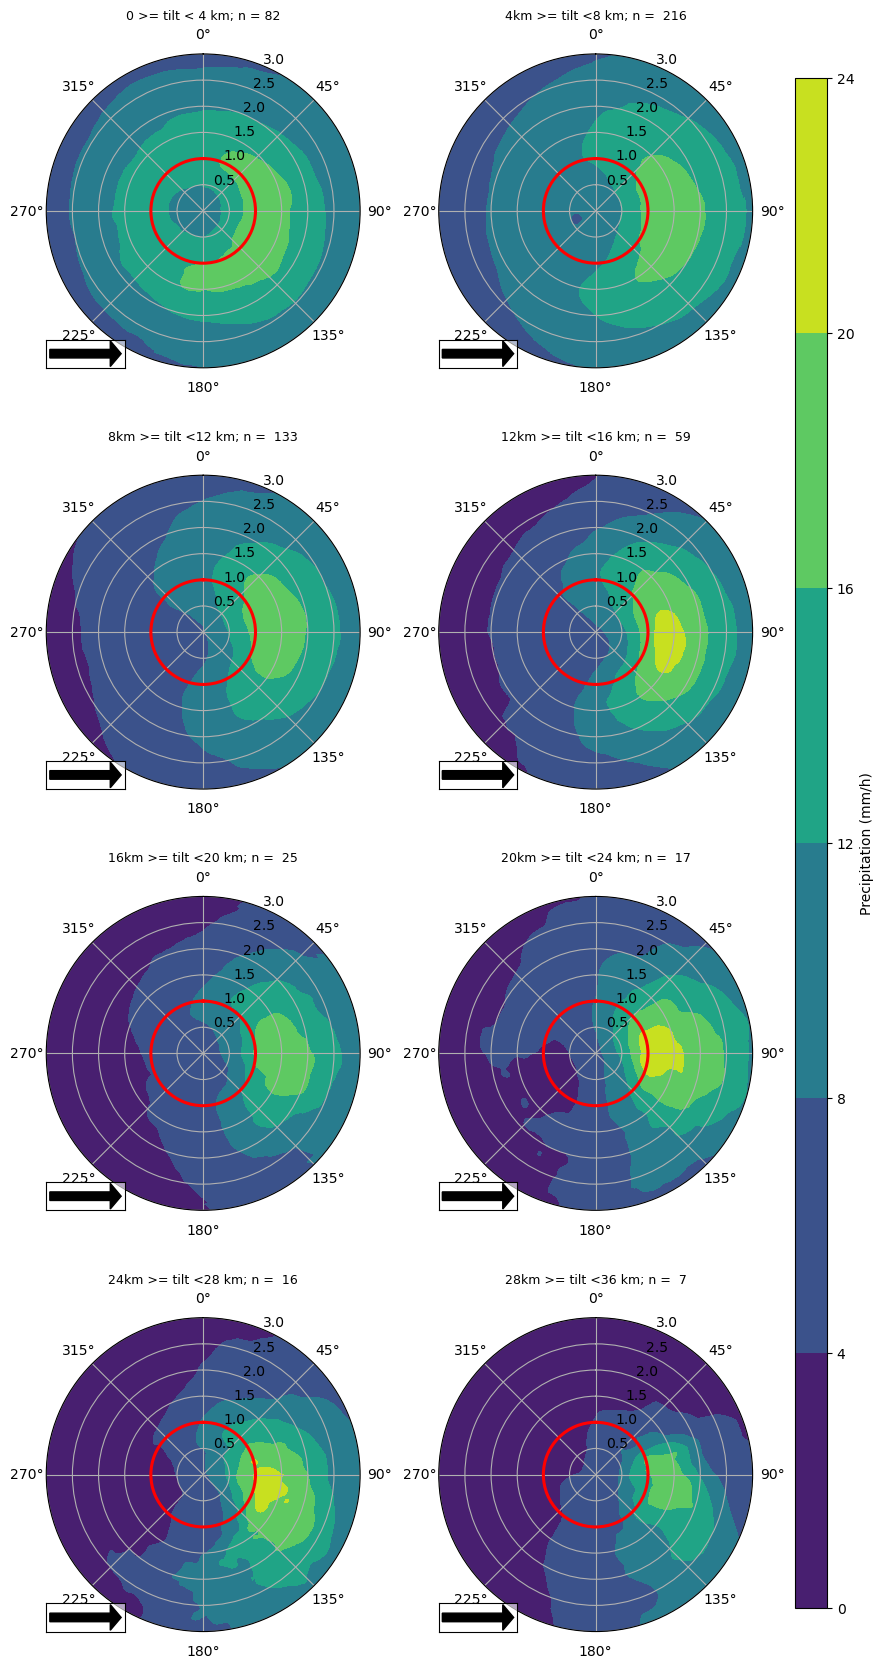

In [21]:
# Make subplots of strong TC precip field with varying tilt bins
fig, ax = plt.subplots(nrows=4, ncols=2,subplot_kw = dict(projection='polar'),figsize=(8, 17))
ax_iteration = 0
plt.tight_layout()

for ax_i in ax.flatten():
    ax_i.grid(True)
#     ax_i.tick_params(axis='both', which='major', labelsize=7)
    ax_i.set_rlim(0,3)
    cf_iter = ax_i.contourf(all_cylindrical_xr['azimuth'],
                all_cylindrical_xr['radius'],
                                   all_cylindrical_xr.sel(case = bin_list[ax_iteration].index).mean('case'),
                           levels=np.arange(0,24.1,4))
    
    n_cases = len(all_cylindrical_xr.sel(case = bin_list[ax_iteration].index))

    if ax_iteration == 0:
        ax_i.set_title('0 >= tilt < '+str(tilt_bin_edges[ax_iteration])+' km; n = ' + str(n_cases),fontsize=9)
    else:
        ax_i.set_title(str(tilt_bin_edges[ax_iteration-1]) + 'km >= tilt <' +
                       str(tilt_bin_edges[ax_iteration]) + ' km; n =  ' + str(n_cases),
                       fontsize=9)
        
    ax_i_gl = ax_i.get_ygridlines()
    ax_i_b = ax_i_gl[1]
    ax_i_b.set_color('red')
    ax_i_b.set_linewidth(2.2)
    ax_i.set_theta_direction(-1)
    ax_i.set_theta_zero_location('N')
    axins_i = inset_axes(ax_i, width="25%", height="9%", loc=3, borderpad=0)
    axins_i.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins_i.patch.set_alpha(0.6)
    q_i = axins_i.arrow(0,0,0.05,0,color='black',head_length = 0.009)
        
    ax_iteration = ax_iteration + 1
cax = plt.axes([1, 0.05, 0.04, 0.9])
plt.colorbar(cf_iter,cax=cax,label='Precipitation (mm/h)')


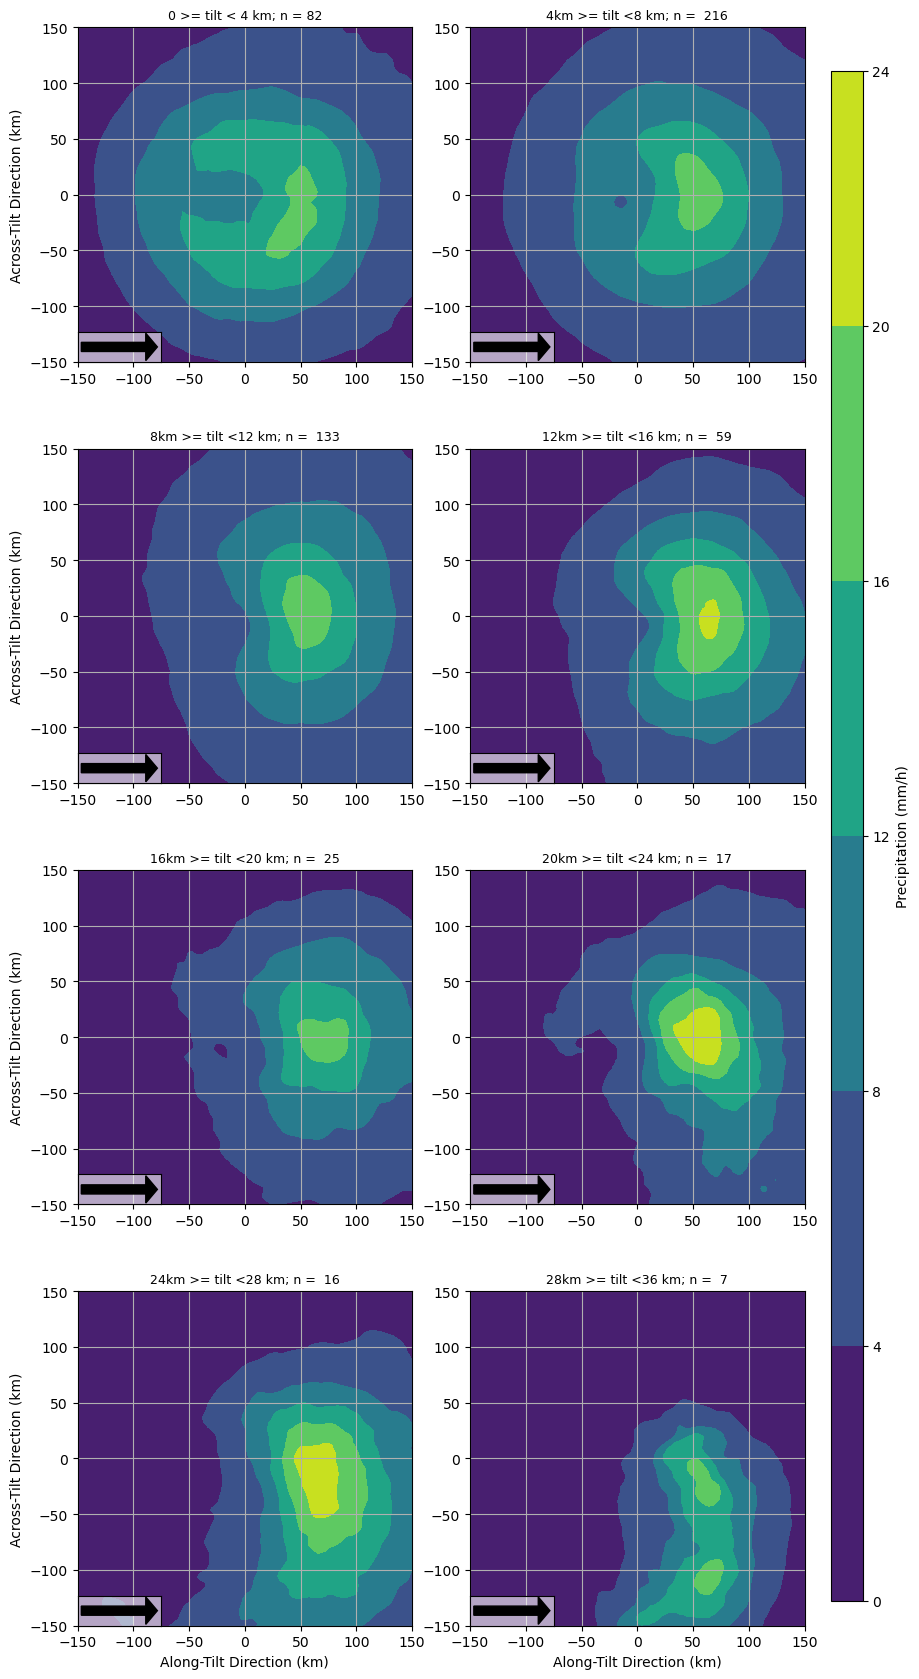

In [22]:
# Make subplots of strong TC precip field with varying tilt bins
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(8, 17),subplot_kw = dict(adjustable='box', aspect=1))
ax_iteration = 0
plt.tight_layout()

for ax_i in ax.flatten():
    ax_i.set_xticks(np.arange(-150,150.1,50))
    ax_i.grid()
#     ax_i.set_xlabel('Along-Tilt Direction (km)')
#     ax_i.set_ylabel('Across-Tilt Direction (km)')

    cf_iter = ax_i.contourf(all_last_slices_xr['x'],
                all_last_slices_xr['y'],
                                   all_last_slices_xr.sel(case = bin_list[ax_iteration].index).mean('case'),
                           levels=np.arange(0,24.1,4))
    
    n_cases = len(all_last_slices_xr.sel(case = bin_list[ax_iteration].index))

    if ax_iteration == 0:
        ax_i.set_title('0 >= tilt < '+str(tilt_bin_edges[ax_iteration])+' km; n = ' + str(n_cases),fontsize=9)
    else:
        ax_i.set_title(str(tilt_bin_edges[ax_iteration-1]) + 'km >= tilt <' +
                       str(tilt_bin_edges[ax_iteration]) + ' km; n =  ' + str(n_cases),
                       fontsize=9)
        
    axins_i = inset_axes(ax_i, width="25%", height="9%", loc=3, borderpad=0)
    axins_i.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins_i.patch.set_alpha(0.6)
    q_i = axins_i.arrow(0,0,0.05,0,color='black',head_length = 0.009)
    
    if (ax_iteration == 6) or (ax_iteration == 7):
        ax_i.set_xlabel('Along-Tilt Direction (km)')
    if (ax_iteration == 0) or (ax_iteration == 2) or (ax_iteration == 4) or (ax_iteration == 6):
        ax_i.set_ylabel('Across-Tilt Direction (km)')
        
    ax_iteration = ax_iteration + 1
    
cax = plt.axes([1, 0.05, 0.04, 0.9])
plt.colorbar(cf_iter,cax=cax,label='Precipitation (mm/h)')


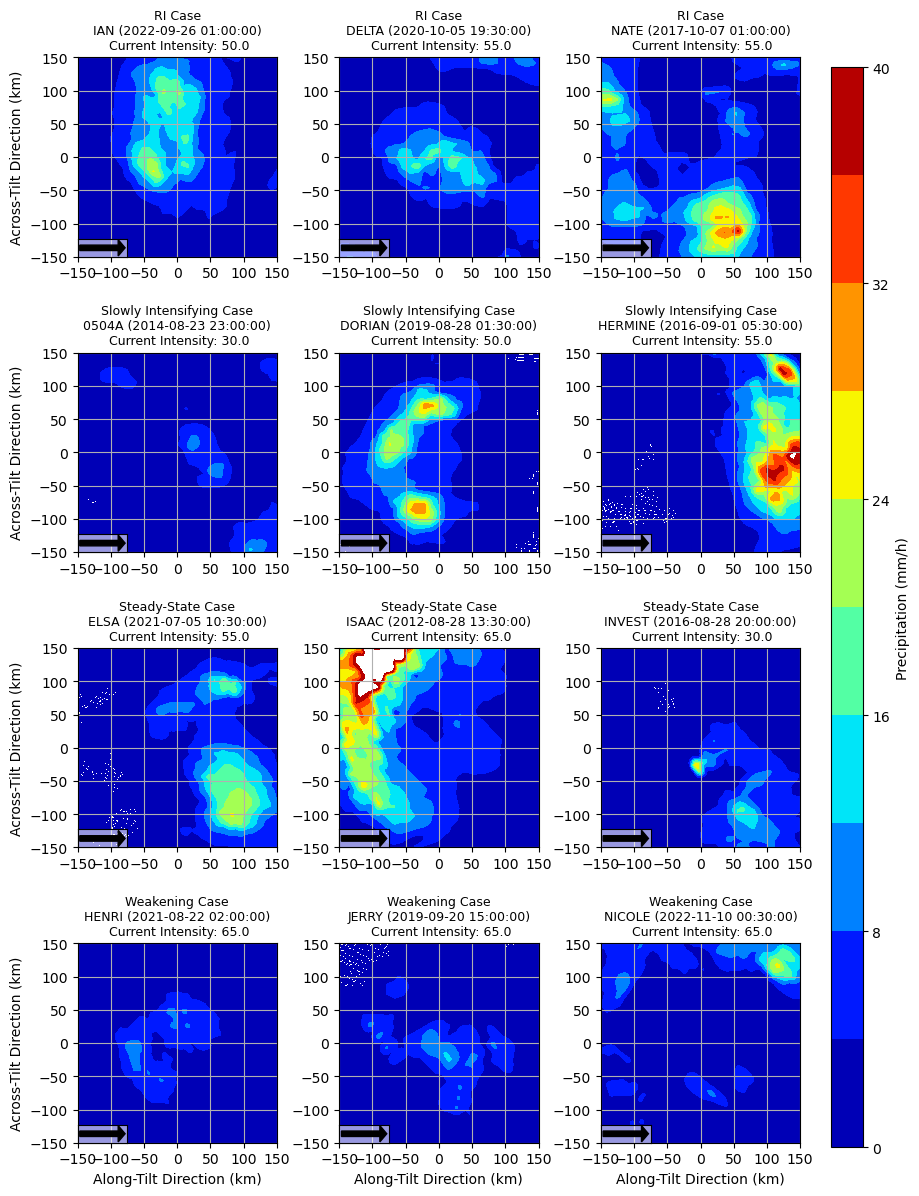

In [23]:
# Plot some individual cases of RI, Slowly Intensifying, SS, and Weakening

# RI_imerg_data = all_last_slices_xr.sel(case = RI_cases.index)
# intensifying_imerg_data = all_last_slices_xr.sel(case = Intensifying_cases.index)
# SS_imerg_data = all_last_slices_xr.sel(case = SS_cases.index)
# weakening_imerg_data = all_last_slices_xr.sel(case = Weakening_cases.index)

data_list = [RI_imerg_data,intensifying_imerg_data,SS_imerg_data,weakening_imerg_data]


import random
RI_deal = random.sample(list(RI_imerg_data['case'].values), 3)
intensifying_deal = random.sample(list(intensifying_imerg_data['case'].values), 3)
SS_deal = random.sample(list(SS_imerg_data['case'].values), 3)
weakening_deal = random.sample(list(weakening_imerg_data['case'].values), 3)

all_plotting_indices = RI_deal +intensifying_deal+ SS_deal+ weakening_deal
chosen_data = all_last_slices_xr.sel(case =all_plotting_indices)
fig, ax = plt.subplots(nrows=4, ncols=3,figsize=(8, 12),subplot_kw = dict(adjustable='box', aspect=1))
ax_iteration = 0
plt.tight_layout()
for ax_i in ax.flatten():
    
    ax_i.set_xticks(np.arange(-150,150.1,50))
    ax_i.grid()
    cf_iter = ax_i.contourf(all_last_slices_xr['x'],
                all_last_slices_xr['y'],
                                   chosen_data[ax_iteration],cmap='jet',
                           levels=np.arange(0,40.1,4))
    
    axins_i = inset_axes(ax_i, width="25%", height="9%", loc=3, borderpad=0)
    axins_i.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins_i.patch.set_alpha(0.6)
    
    if (ax_iteration == 0) or (ax_iteration == 1) or (ax_iteration == 2):
        Current_case = 'RI Case'
    if (ax_iteration == 3) or (ax_iteration == 4) or (ax_iteration == 5):
        Current_case = 'Slowly Intensifying Case'
    if (ax_iteration == 6) or (ax_iteration == 7) or (ax_iteration == 8):
        Current_case = 'Steady-State Case'
    if (ax_iteration == 9) or (ax_iteration == 10) or (ax_iteration == 11):
        Current_case = 'Weakening Case'
        
    ax_i.set_title(Current_case + '\n' + full_info_pd['Storm Name'][all_plotting_indices[ax_iteration]] + ' (' +
                   full_info_pd['Time'][all_plotting_indices[ax_iteration]] +')'+'\n Current Intensity: ' +
                   str(full_info_pd['Intensity'][all_plotting_indices[ax_iteration]]),fontsize=9)
    q_i = axins_i.arrow(0,0,0.05,0,color='black',head_length = 0.009)
    
    if (ax_iteration == 9) or (ax_iteration == 10) or (ax_iteration == 11):
        ax_i.set_xlabel('Along-Tilt Direction (km)')
    if (ax_iteration == 0) or (ax_iteration == 3) or (ax_iteration == 6) or (ax_iteration == 9):
        ax_i.set_ylabel('Across-Tilt Direction (km)')
    
    ax_iteration = ax_iteration + 1

cax = plt.axes([1, 0.05, 0.04, 0.9])
plt.colorbar(cf_iter,cax=cax,label='Precipitation (mm/h)')